In [1]:

import time
start_notebook = time.time()
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Data Preparation
## Read Data

In [2]:
# %cd ..
# %pwd

In [3]:
# Option to generate mock data
generate_mock_data = False # Set to True to generate mock data
max_mock_depth_ft = 2000 # Define maximum depth for mock data
well_name = "LLB-10"
if not generate_mock_data:
  # Load data from local directory
    data = pd.read_csv(f"../data/processed/{well_name}.csv", sep=',')
if generate_mock_data:
    print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name}...")
    mock_depth_step = 0.5
    mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
    num_mock_rows = len(mock_dept_values)

    mock_data_dict = {'DEPT': mock_dept_values}

    feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP'] #complete with all necessary features available in LLB-10

    for col in feature_cols_for_mock:
        mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

    mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

    data = pd.DataFrame(mock_data_dict)

    print(f"Mock data generated for well {well_name} with {num_mock_rows} rows and columns: {list(data.columns)}.")
    print("Mock data head:")
    print(data.head())

## Feature engineering

This section creates engineered features to help models capture petrophysical signals and textures:

- Basic petrophysics: VSH from GR (quantile-normalized), density porosity (PHI_D) and neutron–density separation (PHI_N − PHI_D).
- Contrasts: Z-scored separation between NPHI and RHOB; deep/shallow resistivity ratios and differences when available.
- Windowed textures: Moving average of GR, moving standard deviation of a resistivity curve, and gradient of NPHI over depth.

All features are computed robustly (quantiles, clipping) and only when the required input curves exist.

In [4]:
import numpy as np
import pandas as pd

def compute_engineered_features(df: pd.DataFrame, depth_col: str = "DEPT", window_ft: float = 6.0) -> pd.DataFrame:
    """
    Create engineered features commonly used in petrophysics.

    Inputs
    - df: DataFrame with raw logs, must include depth column and logs where available.
    - depth_col: depth column name (default 'DEPT').
    - window_ft: moving window size in feet. It is advisable to tune this parameter based on the specific dataset and analysis goals.
    - depth_unit: 'ft' or 'm' to scale window. If ft, converts meters to feet (3.28084).
    
    Outputs
    - Copy of df with new feature columns added. Missing sources are skipped.
    """
    out = df.copy()

    # Ensure depth is sorted ascending for rolling/gradient consistency
    if depth_col in out.columns:
        out = out.sort_values(depth_col).reset_index(drop=True)
    
    # Resolve rolling window size in number of samples (depth-based approx)
    # We estimate average sample rate in depth units, then compute window points.
    if depth_col in out.columns and len(out) > 3:
        d = out[depth_col].to_numpy()
        dz = np.diff(d)
        dz = dz[np.isfinite(dz) & (dz != 0)]
        avg_step = np.median(np.abs(dz)) if dz.size else 0.5
    else:
        avg_step = 0.5  # fallback
        
    win_pts = max(3, int(round(window_ft / max(avg_step, 1e-6))))
    win_center = win_pts  # we'll use center=False to keep causal window by default

    # 1) Basic petrophysical calculations
    # VSH from GR: quantile-calibrated clean/shale GR using 5th/95th percentiles
    if "GR" in out.columns:
        gr = out["GR"].astype(float)
        gr_clean = np.nanpercentile(gr, 5)
        gr_shale = np.nanpercentile(gr, 95)
        vsh = (gr - gr_clean) / max(gr_shale - gr_clean, 1e-6)
        out["VSH_QNT"] = vsh.clip(0, 1)
    
    # Apparent density porosity (PHI_D) using RHOB and simple matrix/fluid assumptions
    # phi_d = (rho_ma - rhob) / (rho_ma - rho_f)
    if "RHOB" in out.columns:
        rhob = out["RHOB"].astype(float)
        rho_ma = 2.65  # g/cc, sandstone default
        rho_f = 1.0    # g/cc, formation water
        out["PHI_D"] = ((rho_ma - rhob) / max(rho_ma - rho_f, 1e-6)).clip(-0.05, 0.6)
    
    # Use neutron porosity as-is if present and compute separation (gas indicator)
    # Normalize to comparable scale before difference to reduce unit biases
    if "NPHI" in out.columns:
        out["PHI_N"] = out["NPHI"].astype(float)
    
    if "PHI_D" in out.columns and "PHI_N" in out.columns:
        # Z-score by rolling mean/std to reflect local contrasts
        phi_d_z = (out["PHI_D"] - out["PHI_D"].rolling(win_pts, min_periods=3).mean()) \
                  / (out["PHI_D"].rolling(win_pts, min_periods=3).std() + 1e-6)
        phi_n_z = (out["PHI_N"] - out["PHI_N"].rolling(win_pts, min_periods=3).mean()) \
                  / (out["PHI_N"].rolling(win_pts, min_periods=3).std() + 1e-6)
        out["ND_SEP"] = (phi_n_z - phi_d_z).replace([np.inf, -np.inf], np.nan)
    
    # 2) Resistivity ratios/differences (choose available columns heuristically)
    # Try shallow vs deep: common naming like MSFL (shallow), RATIO/RA* etc. Use what exists.
    # Check candidate deep curves
    deep_candidates = [c for c in out.columns if c.upper() in ["RT", "ILD", "RDEP", "RPD", "DEEPRES", "RPCHM", "RPCLM"]]
    shallow_candidates = [c for c in out.columns if c.upper() in ["RS", "MSFL", "SFLU", "RMED", "RM", "RPCSHM", "RPCSLM"]]
    deep_col = deep_candidates[0] if deep_candidates else None
    shallow_col = shallow_candidates[0] if shallow_candidates else None
    
    if deep_col is not None and shallow_col is not None:
        rd = out[deep_col].astype(float)
        rs = out[shallow_col].astype(float)
        out[f"RES_RATIO_{deep_col}_{shallow_col}"] = (rd / (rs + 1e-6)).replace([np.inf, -np.inf], np.nan)
        out[f"RES_DIFF_{deep_col}_{shallow_col}"] = (rd - rs)
    
    # 3) Windowed (convolutional) features
    # Moving averages
    if "GR" in out.columns:
        out["GR_MA"] = out["GR"].rolling(win_pts, min_periods=3).mean()
        out["GR_STD"] = out["GR"].rolling(win_pts, min_periods=3).std()
    
    # Use a resistivity-like curve for texture stats if available
    rt_like = None
    for c in ["RT", "ILD", "RDEP", "DEEPRES", "RPCHM", "RPCLM", "RM", "MSFL", "SFLU"]:
        if c in out.columns:
            rt_like = c
            break
    if rt_like is not None:
        out[f"{rt_like}_MA"] = out[rt_like].rolling(win_pts, min_periods=3).mean()
        out[f"{rt_like}_STD"] = out[rt_like].rolling(win_pts, min_periods=3).std()
    
    # Gradient of neutron porosity with respect to depth
    if depth_col in out.columns and "PHI_N" in out.columns:
        d = out[depth_col].to_numpy()
        phi = out["PHI_N"].to_numpy()
        grad = np.full_like(phi, np.nan, dtype=float)
        with np.errstate(divide='ignore', invalid='ignore'):
            grad[1:-1] = (phi[2:] - phi[:-2]) / (d[2:] - d[:-2])
        out["PHI_N_GRAD"] = grad
    
    # Clean up extreme values
    for col in out.columns:
        if out[col].dtype.kind in "fc" and out[col].isna().mean() < 0.99:
            # Winsorize to robust range
            lo, hi = np.nanpercentile(out[col], [0.1, 99.9])
            if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
                out[col] = out[col].clip(lo, hi)
    
    print("Engineered feature columns added:")
    new_cols = sorted(set(out.columns) - set(df.columns))
    print(new_cols[:25], ' \n total new:', len(new_cols))
    
    return out

# Apply feature engineering
data = compute_engineered_features(data, depth_col='DEPT')

Engineered feature columns added:
['GR_MA', 'GR_STD', 'ND_SEP', 'PHI_D', 'PHI_N', 'PHI_N_GRAD', 'RES_DIFF_RPCHM_RPCSHM', 'RES_RATIO_RPCHM_RPCSHM', 'RPCHM_MA', 'RPCHM_STD', 'VSH_QNT']  
 total new: 11


## Features used for machine learning

In [5]:
feature_cols = ['DRHO','GR','SR','MR','NPHI','RHOB','GR_MA', 'GR_STD', 'ND_SEP', 'PHI_D', 'PHI_N', 'PHI_N_GRAD', 'VSH_QNT']

In [6]:
df=data[feature_cols]

In [7]:
df = df.fillna(df.mean())

In [8]:
df

,DRHO,GR,SR,MR,NPHI,RHOB,GR_MA,GR_STD,ND_SEP,PHI_D,PHI_N,PHI_N_GRAD,VSH_QNT
0,0.051,88.200,0.737,0.875,0.484100,2.103,60.190927,4.237963,0.052810,0.331515,0.484100,-0.000053,1.000000
1,0.050,85.650,0.741,0.874,0.474400,2.130,60.190927,4.237963,0.052810,0.315152,0.474400,0.000400,1.000000
2,0.064,79.358,0.779,0.900,0.484500,2.177,81.712466,4.551057,1.688869,0.286667,0.484500,0.073100,1.000000
3,0.077,74.004,0.802,0.917,0.547500,2.184,81.712466,6.390708,2.403476,0.282424,0.547500,0.119357,0.963974
4,0.081,78.938,0.840,0.973,0.593575,2.142,81.230000,5.680890,1.381093,0.307879,0.593575,0.018200,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7156,0.206,48.022,1.897,1.943,0.322200,2.595,47.592833,1.291590,1.480856,0.033333,0.322200,-0.011800,0.237814
7157,0.158,51.742,1.858,1.981,0.319900,2.555,47.847000,1.747270,0.632630,0.057576,0.319900,0.005600,0.341783
7158,0.089,54.041,1.919,2.015,0.327800,2.477,48.410250,2.483068,-0.169645,0.104848,0.327800,0.011600,0.406037
7159,0.052,52.710,1.883,1.962,0.331500,2.432,48.923250,2.691840,-0.596643,0.132121,0.331500,-0.006000,0.368837


## Train/Test Splitting

In [9]:
# Misalkan 'data' adalah DataFrame Anda dan 'df' adalah fitur yang telah Anda ekstrak
X = df  # Fitur
y = data['hydrocarbon_formation_class']  # Label

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
X_train.describe()

,DRHO,GR,SR,MR,NPHI,RHOB,GR_MA,GR_STD,ND_SEP,PHI_D,PHI_N,PHI_N_GRAD,VSH_QNT
count,5728.000000,5728.000000,5728.00000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000
mean,0.151533,60.152024,1.22930,1.418177,0.410584,2.341591,60.204960,4.246552,0.042264,0.187039,0.410584,0.000015,0.577718
std,0.104392,11.002986,0.68357,0.942093,0.052871,0.114144,9.963683,2.246853,1.530706,0.068702,0.052871,0.025943,0.285612
min,-0.169245,24.905280,0.55180,0.568480,0.150207,1.852226,30.299478,0.807591,-4.084190,-0.050000,0.150207,-0.123880,0.000000
25%,0.089000,53.034000,1.00700,1.086000,0.382800,2.285000,53.825542,2.679424,-0.957166,0.146061,0.382800,-0.014000,0.377893
50%,0.133000,62.135000,1.09500,1.224000,0.407900,2.351000,62.571000,3.808053,0.026695,0.181212,0.407900,0.000600,0.632253
75%,0.186000,68.128500,1.23900,1.423000,0.442825,2.409000,67.238479,5.238475,1.029995,0.221212,0.442825,0.014100,0.799762
max,0.681350,88.200840,10.93232,13.810280,0.593575,2.840046,81.712466,16.372399,4.540739,0.483499,0.593575,0.119357,1.000000


## Data Imbalance Handling

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Apply SMOTE to the training data
# # X_train and y_train are available from CELL INDEX 10
# print("Original training data shape:", X_train.shape, y_train.shape)
# print("Original training class distribution:\n", y_train.value_counts())

# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print("\nShape of training data after SMOTE:", X_train_smote.shape, y_train_smote.shape)
# print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# # Update X_train and y_train to be the oversampled versions
# X_train = X_train_smote
# y_train = y_train_smote

## Apply Quantile Transformation

In [13]:
from sklearn.preprocessing import QuantileTransformer
def transform_quantile(X_train, X_test, X):
    qt_transformer = QuantileTransformer(output_distribution='normal')
    dfs = [X_train, X_test, X]
    qt_dfs = [None,None,None]
    for i, df in enumerate(dfs):
        if (i == 0): #only perform fit_transform on training data
            qt_dfs[i] = pd.DataFrame(qt_transformer.fit_transform(df))
        else:
            qt_dfs[i] = pd.DataFrame(qt_transformer.transform(df))
        qt_dfs[i].columns = df.columns.values
        qt_dfs[i].index = df.index.values
    return qt_dfs[0], qt_dfs[1], qt_dfs[2] #X_train, X_test, X

In [14]:
X_train, X_test, X = transform_quantile(X_train, X_test, X)

## Feature Scaling

karena menggunakan Quatile transformation dengan output gaussian, masing masing kolom secara otomatis ditransformasi ke distribusi normal baku, atau distribusi normal dengan rataan nol dan standar deviasi 1, oleh karena itu tidak diperlukan tambahan scaling.

In [15]:
X_train.describe()

,DRHO,GR,SR,MR,NPHI,RHOB,GR_MA,GR_STD,ND_SEP,PHI_D,PHI_N,PHI_N_GRAD,VSH_QNT
count,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000
mean,-0.005226,0.000333,0.000384,-0.000033,-0.000062,-0.000355,-0.000079,-0.000013,-0.000040,-0.004494,-0.000062,-0.000656,-0.001251
std,1.034445,1.018671,1.018724,1.017164,1.016954,1.018468,1.014283,1.020070,1.019958,1.037523,1.016954,1.017092,1.803622
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.683178,-0.674510,-0.676854,-0.672129,-0.673702,-0.675277,-0.675491,-0.674654,-0.674341,-0.680013,-0.673702,-0.675277,-0.674510
50%,0.003764,-0.000083,0.001255,0.000000,-0.001255,0.001255,0.000422,-0.000521,-0.000849,-0.001255,-0.001255,-0.001255,-0.000083
75%,0.675277,0.674798,0.673702,0.674938,0.675078,0.680013,0.674430,0.674004,0.674459,0.675277,0.675078,0.673702,0.674798
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


# Training setup

In [16]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV


train_accuracy={}
test_accuracy={}

crossValidation_accuracy={}

models = {} #sklearn models

times = {}

pred = {}

pred_times = {}

# Models

## SVM

In [17]:
model_name = "SVM"

In [18]:
from sklearn.svm import SVC as SklearnSVC

In [19]:
# Parameter grid for both models
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# 1) scikit-learn SVM with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnSVC(kernel='rbf', probability=True),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
scikit-learn GridSearchCV training time (SVM) : 5.84 seconds
scikit-learn Best parameters (SVM): {'C': 10, 'gamma': 'auto'}


## K-Nearest Neighbors

In [20]:
model_name = "KNN"

In [21]:
from sklearn.neighbors import KNeighborsClassifier as SklearnKNeighborsClassifier

In [22]:
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 1) scikit-learn KNN with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnKNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
scikit-learn GridSearchCV training time (KNN) : 0.86 seconds
scikit-learn Best parameters (KNN): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Random Forest

In [23]:
model_name = "RF"

In [24]:
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier

In [25]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
}

# 1) scikit-learn RandomForest with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnRandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5, # Using 3-fold CV for RF due to potentially longer training times
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start



print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
scikit-learn GridSearchCV training time (RF) : 6.34 seconds
scikit-learn Best parameters (RF): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


## XGBoost Model

In [26]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to penalize minority class mistakes more heavily
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[0] / class_weights[1]  # ratio for minority class weighting

model_name = "XGBoost"

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# XGBoost with GridSearchCV and class weighting
models[model_name] = GridSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        eval_metric='logloss'
    ),
    param_grid=param_grid_xgb,
    cv=5,
    verbose=3,
    n_jobs=-1,
    scoring='f1'  # F1 score is better for imbalanced datasets
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")
print(f"Class weight ratio (scale_pos_weight): {scale_pos_weight:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
scikit-learn GridSearchCV training time (XGBoost) : 2.67 seconds
scikit-learn Best parameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}
Class weight ratio (scale_pos_weight): 0.0671


## LightGBM Model

In [27]:
import lightgbm as lgb

model_name = "LightGBM"

# Calculate class weights for LightGBM
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'num_leaves': [31, 62],
}

# LightGBM with GridSearchCV and class weighting
models[model_name] = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        random_state=42,
        class_weight=class_weight_dict,  # Handle class imbalance
        verbosity=-1  # Reduce output verbosity
    ),
    param_grid=param_grid_lgb,
    cv=5,
    verbose=3,
    n_jobs=-1,
    scoring='f1'  # F1 score is better for imbalanced datasets
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")
print(f"Class weights: {class_weight_dict}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
scikit-learn GridSearchCV training time (LightGBM) : 36.61 seconds
scikit-learn Best parameters (LightGBM): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'num_leaves': 62, 'subsample': 0.8}
Class weights: {0: np.float64(0.533532041728763), 1: np.float64(7.955555555555556)}


# LLB-10 Prediction & Model Evaluation

--- Evaluating: SVM ---

-- scikit-learn --
Prediction Duration: 0.17 seconds
Train Accuracy: 0.9850
Test Accuracy: 0.9714
Test F1-Score: 0.7285
Test AUC-ROC: 0.9708
Best Cross-Validation Score: 0.9770
Training Duration: 5.84 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1343
           1       0.90      0.61      0.73        90

    accuracy                           0.97      1433
   macro avg       0.94      0.80      0.86      1433
weighted avg       0.97      0.97      0.97      1433

Confusion Matrix (Test Set):


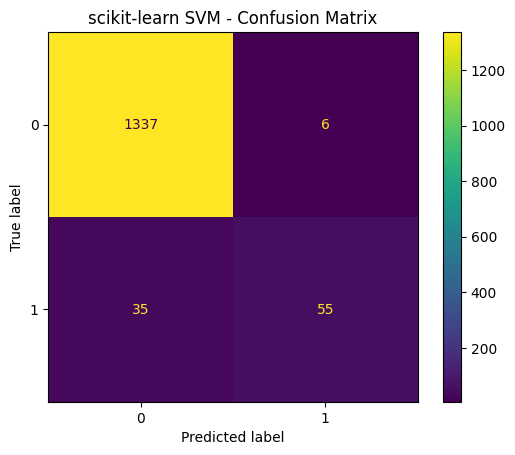



--- Evaluating: KNN ---

-- scikit-learn --
Prediction Duration: 0.23 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9721
Test F1-Score: 0.7468
Test AUC-ROC: 0.9418
Best Cross-Validation Score: 0.9698
Training Duration: 0.86 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.87      0.66      0.75        90

    accuracy                           0.97      1433
   macro avg       0.92      0.82      0.87      1433
weighted avg       0.97      0.97      0.97      1433

Confusion Matrix (Test Set):


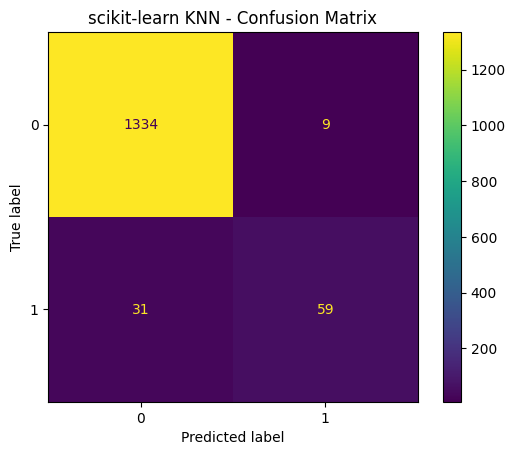



--- Evaluating: RF ---

-- scikit-learn --
Prediction Duration: 0.01 seconds
Train Accuracy: 0.9998
Test Accuracy: 0.9651
Test F1-Score: 0.6377
Test AUC-ROC: 0.9870
Best Cross-Validation Score: 0.9705

Feature Importance (RF):
  SR: 0.1782
  MR: 0.1518
  GR_MA: 0.1087
  PHI_D: 0.0697
  PHI_N: 0.0636
  GR_STD: 0.0630
  RHOB: 0.0611
  NPHI: 0.0600
  GR: 0.0578
  VSH_QNT: 0.0554
  ND_SEP: 0.0492
  DRHO: 0.0456
  PHI_N_GRAD: 0.0357
Training Duration: 6.34 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1343
           1       0.92      0.49      0.64        90

    accuracy                           0.97      1433
   macro avg       0.94      0.74      0.81      1433
weighted avg       0.96      0.97      0.96      1433

Confusion Matrix (Test Set):


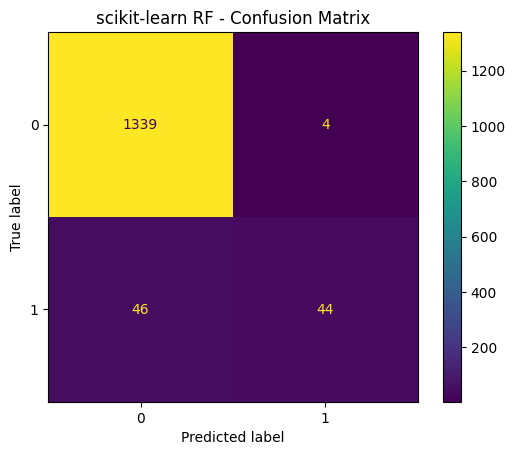



--- Evaluating: XGBoost ---

-- scikit-learn --
Prediction Duration: 0.00 seconds
Train Accuracy: 0.9785
Test Accuracy: 0.9630
Test F1-Score: 0.5891
Test AUC-ROC: 0.9786
Best Cross-Validation Score: 0.6104

Feature Importance (XGBoost):
  GR_MA: 0.1514
  SR: 0.1456
  NPHI: 0.1149
  MR: 0.1027
  RHOB: 0.0877
  VSH_QNT: 0.0745
  GR: 0.0699
  PHI_D: 0.0649
  GR_STD: 0.0618
  DRHO: 0.0543
  ND_SEP: 0.0439
  PHI_N_GRAD: 0.0286
  PHI_N: 0.0000
Training Duration: 2.67 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1343
           1       0.97      0.42      0.59        90

    accuracy                           0.96      1433
   macro avg       0.97      0.71      0.78      1433
weighted avg       0.96      0.96      0.96      1433

Confusion Matrix (Test Set):


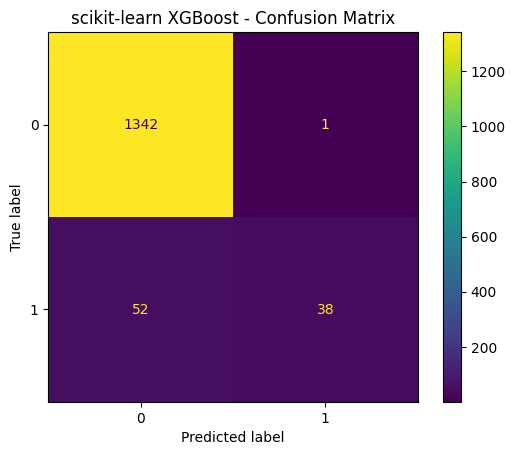



--- Evaluating: LightGBM ---

-- scikit-learn --
Prediction Duration: 0.00 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9839
Test F1-Score: 0.8606
Test AUC-ROC: 0.9926
Best Cross-Validation Score: 0.8670

Feature Importance (LightGBM):
  MR: 815.0000
  SR: 784.0000
  GR_MA: 775.0000
  NPHI: 609.0000
  GR_STD: 603.0000
  DRHO: 532.0000
  RHOB: 487.0000
  ND_SEP: 435.0000
  GR: 397.0000
  PHI_N_GRAD: 342.0000
  PHI_D: 142.0000
  VSH_QNT: 99.0000
  PHI_N: 0.0000
Training Duration: 36.61 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.95      0.79      0.86        90

    accuracy                           0.98      1433
   macro avg       0.97      0.89      0.93      1433
weighted avg       0.98      0.98      0.98      1433

Confusion Matrix (Test Set):


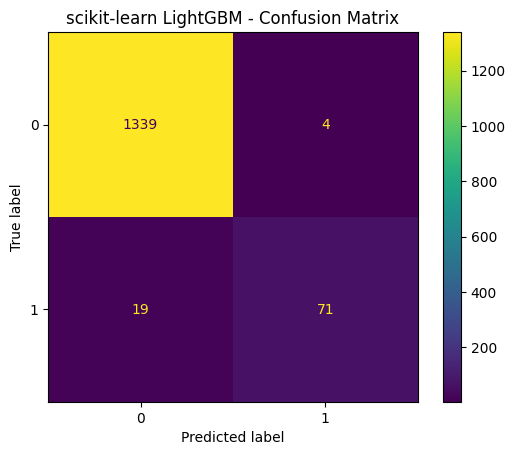




Summary of All Metrics:
Train Accuracies: {'SVM': 0.984986033519553, 'KNN': 1.0, 'RF': 0.9998254189944135, 'XGBoost': 0.9785265363128491, 'LightGBM': 1.0}
Test Accuracies: {'SVM': 0.9713886950453594, 'KNN': 0.9720865317515701, 'RF': 0.9651081646894627, 'XGBoost': 0.9630146545708305, 'LightGBM': 0.9839497557571528}
Test F1-Scores: {'SVM': 0.7284768211920529, 'KNN': 0.7468354430379747, 'RF': 0.6376811594202898, 'XGBoost': 0.5891472868217055, 'LightGBM': 0.8606060606060606}
Test AUC-ROC Scores: {'SVM': np.float64(0.9707537023248117), 'KNN': np.float64(0.9418424753867791), 'RF': np.float64(0.9869653346570697), 'XGBoost': np.float64(0.978646479688922), 'LightGBM': np.float64(0.9925953503764375)}
Cross-Validation Accuracies: {'SVM': np.float64(0.976956034660143), 'KNN': np.float64(0.9697962916390406), 'RF': np.float64(0.9704942194989978), 'XGBoost': np.float64(0.6103803426965702), 'LightGBM': np.float64(0.8670161568657809)}
Training Times: {'SVM': 5.840675592422485, 'KNN': 0.8595654964447

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionaries for new metrics
f1_scores = {}
auc_scores = {}
feature_importances = {}

# --- Comparison and Evaluation ---
model_names = list(models.keys()) # Assuming cu_models will have the same keys if cuML is available

for model_name in model_names:
    print(f"--- Evaluating: {model_name} ---")

    # --- scikit-learn model ---
    if model_name in models:
        print("\n-- scikit-learn --")
        best_sk_model = models[model_name].best_estimator_

        # Predictions
        y_pred_train_sk = best_sk_model.predict(X_train)
        y_pred_test_sk = best_sk_model.predict(X_test)
        
        # Get prediction probabilities for AUC calculation (if available)
        try:
            y_pred_proba_test_sk = best_sk_model.predict_proba(X_test)[:, 1]
            auc_available = True
        except AttributeError:
            print("Note: predict_proba not available for this model - AUC cannot be calculated")
            auc_available = False
        
        start_time = time.time()
        pred[model_name] = best_sk_model.predict(X)
        end_time = time.time()
        pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {pred_times[model_name]:.2f} seconds")

        # Accuracy
        train_accuracy_sk = accuracy_score(y_train, y_pred_train_sk)
        test_accuracy_sk = accuracy_score(y_test, y_pred_test_sk)
        train_accuracy[model_name] = train_accuracy_sk
        test_accuracy[model_name] = test_accuracy_sk
        print(f"Train Accuracy: {train_accuracy_sk:.4f}")
        print(f"Test Accuracy: {test_accuracy_sk:.4f}")

        # F1-Score
        f1_test_sk = f1_score(y_test, y_pred_test_sk)
        f1_scores[model_name] = f1_test_sk
        print(f"Test F1-Score: {f1_test_sk:.4f}")
        
        # AUC-ROC (only if probabilities are available)
        if auc_available:
            auc_test_sk = roc_auc_score(y_test, y_pred_proba_test_sk)
            auc_scores[model_name] = auc_test_sk
            print(f"Test AUC-ROC: {auc_test_sk:.4f}")
        else:
            auc_scores[model_name] = np.nan
            print("Test AUC-ROC: N/A (requires probability predictions)")

        # Cross-validation score
        cv_score_sk = models[model_name].best_score_
        crossValidation_accuracy[model_name] = cv_score_sk
        print(f"Best Cross-Validation Score: {cv_score_sk:.4f}")

        # Feature Importance for tree-based models
        if hasattr(best_sk_model, 'feature_importances_'):
            importances = best_sk_model.feature_importances_
            feature_importances[model_name] = dict(zip(feature_cols, importances))
            
            print(f"\nFeature Importance ({model_name}):")
            # Sort features by importance
            sorted_features = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features:
                print(f"  {feature}: {importance:.4f}")

        # Duration
        print(f"Training Duration: {times[model_name]:.2f} seconds")

        print("Classification Report (Test Set):")
        print(classification_report(y_test, y_pred_test_sk))

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_sk = confusion_matrix(y_test, y_pred_test_sk)
        disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=best_sk_model.classes_)
        disp_sk.plot()
        plt.title(f"scikit-learn {model_name} - Confusion Matrix")
        plt.show()


    print("\n" + "="*40 + "\n")

print("\nSummary of All Metrics:")
print("Train Accuracies:", train_accuracy)
print("Test Accuracies:", test_accuracy)
print("Test F1-Scores:", f1_scores)
print("Test AUC-ROC Scores:", auc_scores)
print("Cross-Validation Accuracies:", crossValidation_accuracy)
print("Training Times:", times)
print("Prediction Times:", pred_times)

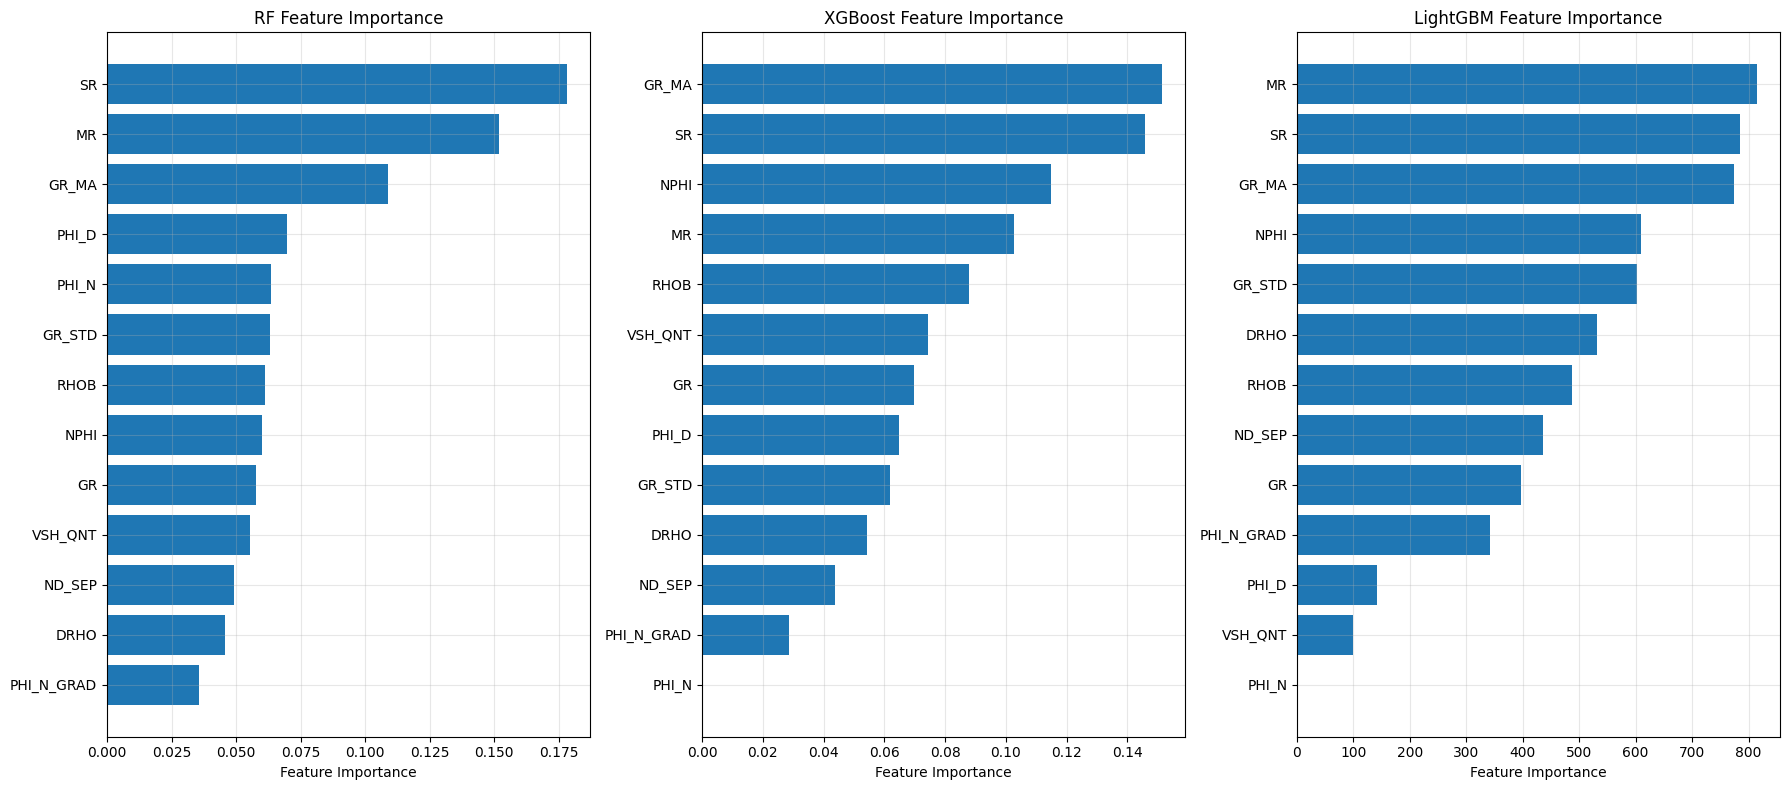

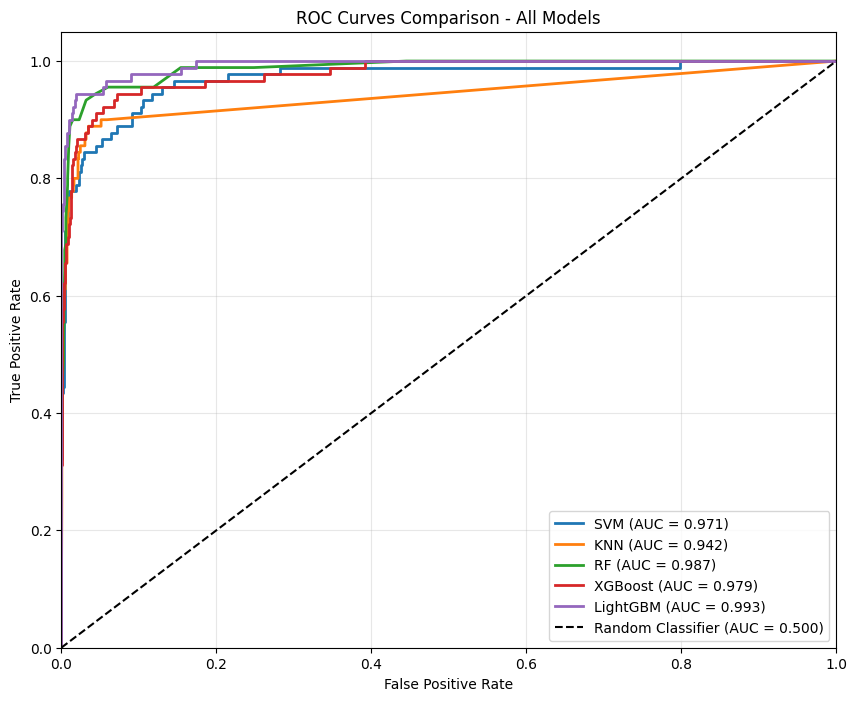

In [29]:
# Feature Importance Plots for Tree-based Models
tree_models = [name for name in model_names if name in ['RF', 'XGBoost', 'LightGBM']]

if len(tree_models) > 0:
    fig, axes = plt.subplots(1, len(tree_models), figsize=(6*len(tree_models), 8))
    if len(tree_models) == 1:
        axes = [axes]
    
    for i, model_name in enumerate(tree_models):
        if model_name in feature_importances:
            features = list(feature_importances[model_name].keys())
            importances = list(feature_importances[model_name].values())
            
            # Sort by importance
            sorted_idx = np.argsort(importances)
            
            axes[i].barh(range(len(features)), [importances[j] for j in sorted_idx])
            axes[i].set_yticks(range(len(features)))
            axes[i].set_yticklabels([features[j] for j in sorted_idx])
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_title(f'{model_name} Feature Importance')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ROC Curves Comparison
plt.figure(figsize=(10, 8))

for model_name in model_names:
    if model_name in models:
        best_sk_model = models[model_name].best_estimator_
        y_pred_proba = best_sk_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc_scores[model_name]
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# Create comprehensive metrics comparison table
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': model_names,
    'Test_Accuracy': [test_accuracy[model] for model in model_names],
    'F1_Score': [f1_scores[model] for model in model_names],
    'AUC_ROC': [auc_scores[model] for model in model_names],
    'CV_Score': [crossValidation_accuracy[model] for model in model_names],
    'Training_Time': [times[model] for model in model_names],
    'Prediction_Time': [pred_times[model] for model in model_names]
})

# Sort by F1-Score (most important for imbalanced datasets)
metrics_df = metrics_df.sort_values('F1_Score', ascending=False)

print("=" * 80)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print("\nNote: For imbalanced datasets, F1-Score and AUC-ROC are more reliable than accuracy")
print("\nMetrics Ranked by F1-Score (Best to Worst):")
print(metrics_df.to_string(index=False, float_format='%.4f'))

# Highlight the best performing model
best_model = metrics_df.iloc[0]['Model']
best_f1 = metrics_df.iloc[0]['F1_Score']
best_auc = metrics_df.iloc[0]['AUC_ROC']

print(f"\n BEST PERFORMING MODEL: {best_model}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   AUC-ROC: {best_auc:.4f}")
print("\nInterpretation:")
print("- F1-Score: Harmonic mean of precision and recall (0-1, higher is better)")
print("- AUC-ROC: Area under ROC curve (0.5=random, 1.0=perfect)")
print("- For hydrocarbon detection, high recall (finding pay zones) is critical!")

COMPREHENSIVE MODEL PERFORMANCE COMPARISON

Note: For imbalanced datasets, F1-Score and AUC-ROC are more reliable than accuracy

Metrics Ranked by F1-Score (Best to Worst):
   Model  Test_Accuracy  F1_Score  AUC_ROC  CV_Score  Training_Time  Prediction_Time
LightGBM         0.9839    0.8606   0.9926    0.8670        36.6074           0.0046
     KNN         0.9721    0.7468   0.9418    0.9698         0.8596           0.2287
     SVM         0.9714    0.7285   0.9708    0.9770         5.8407           0.1652
      RF         0.9651    0.6377   0.9870    0.9705         6.3350           0.0101
 XGBoost         0.9630    0.5891   0.9786    0.6104         2.6741           0.0035

 BEST PERFORMING MODEL: LightGBM
   F1-Score: 0.8606
   AUC-ROC: 0.9926

Interpretation:
- F1-Score: Harmonic mean of precision and recall (0-1, higher is better)
- AUC-ROC: Area under ROC curve (0.5=random, 1.0=perfect)
- For hydrocarbon detection, high recall (finding pay zones) is critical!


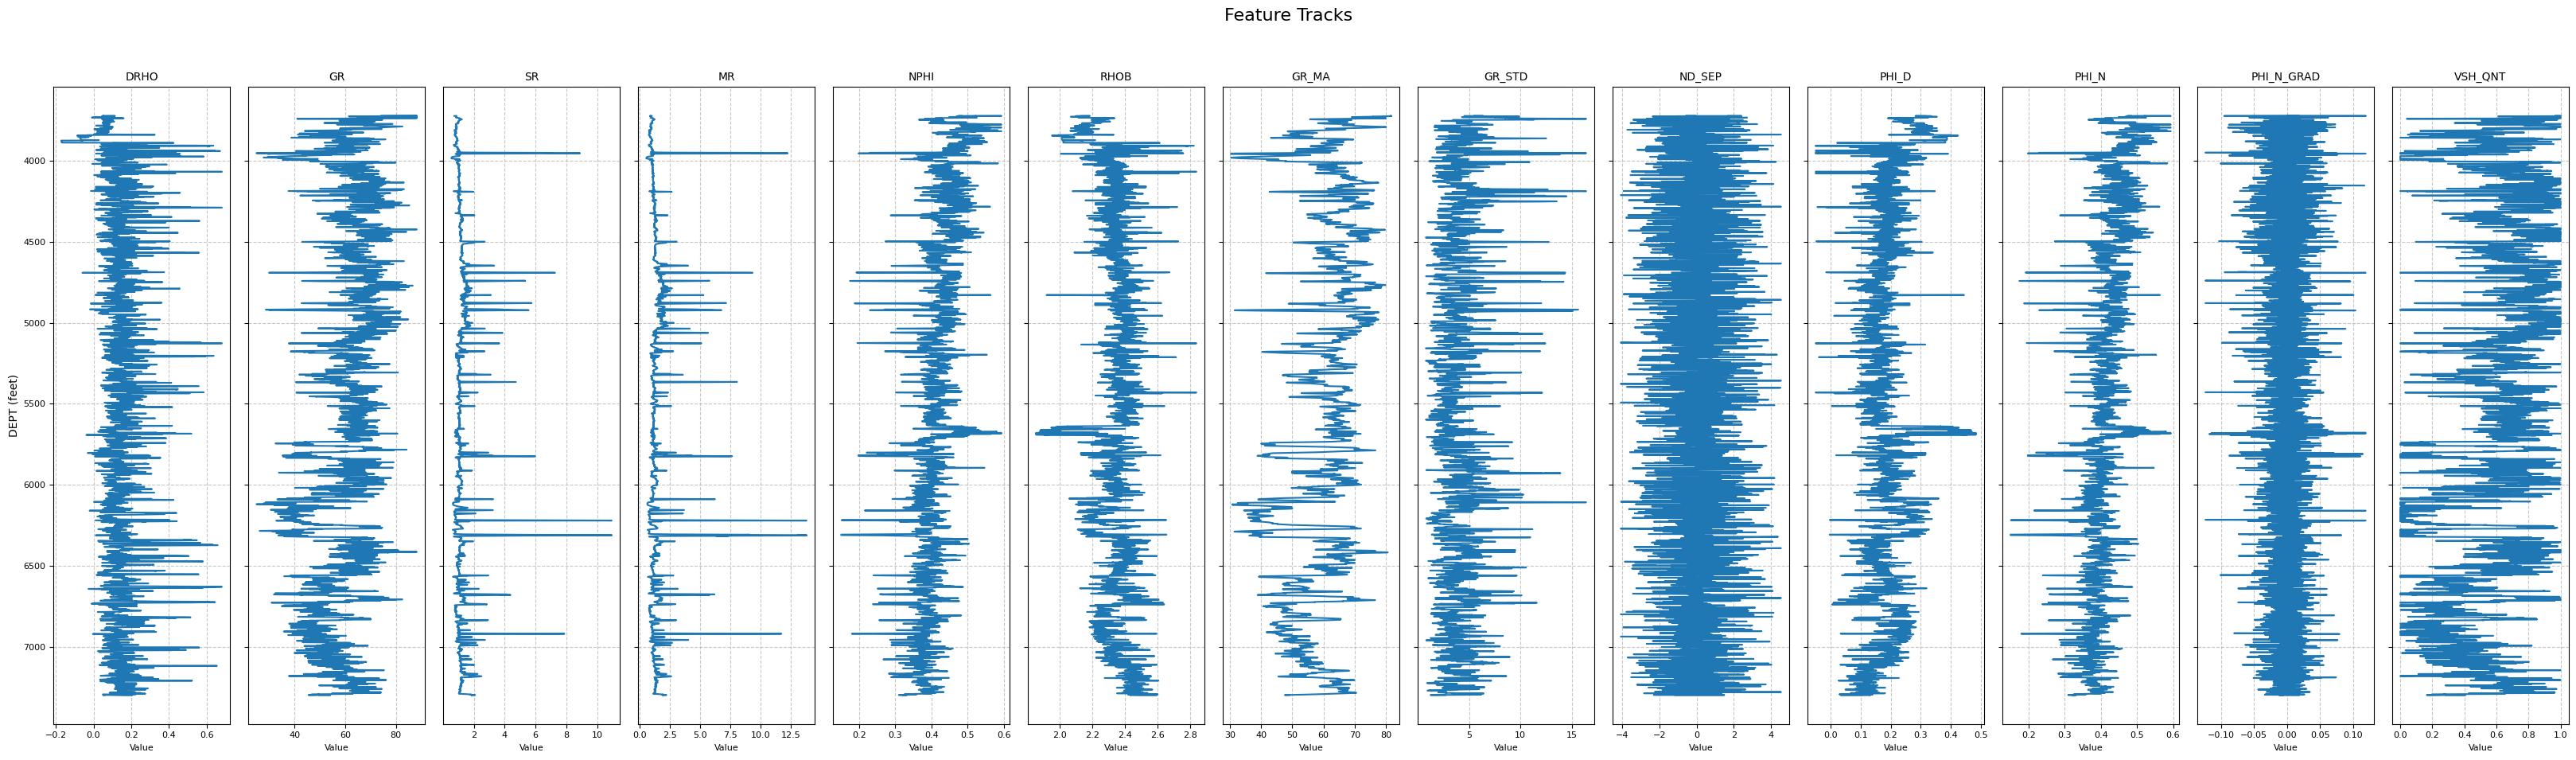

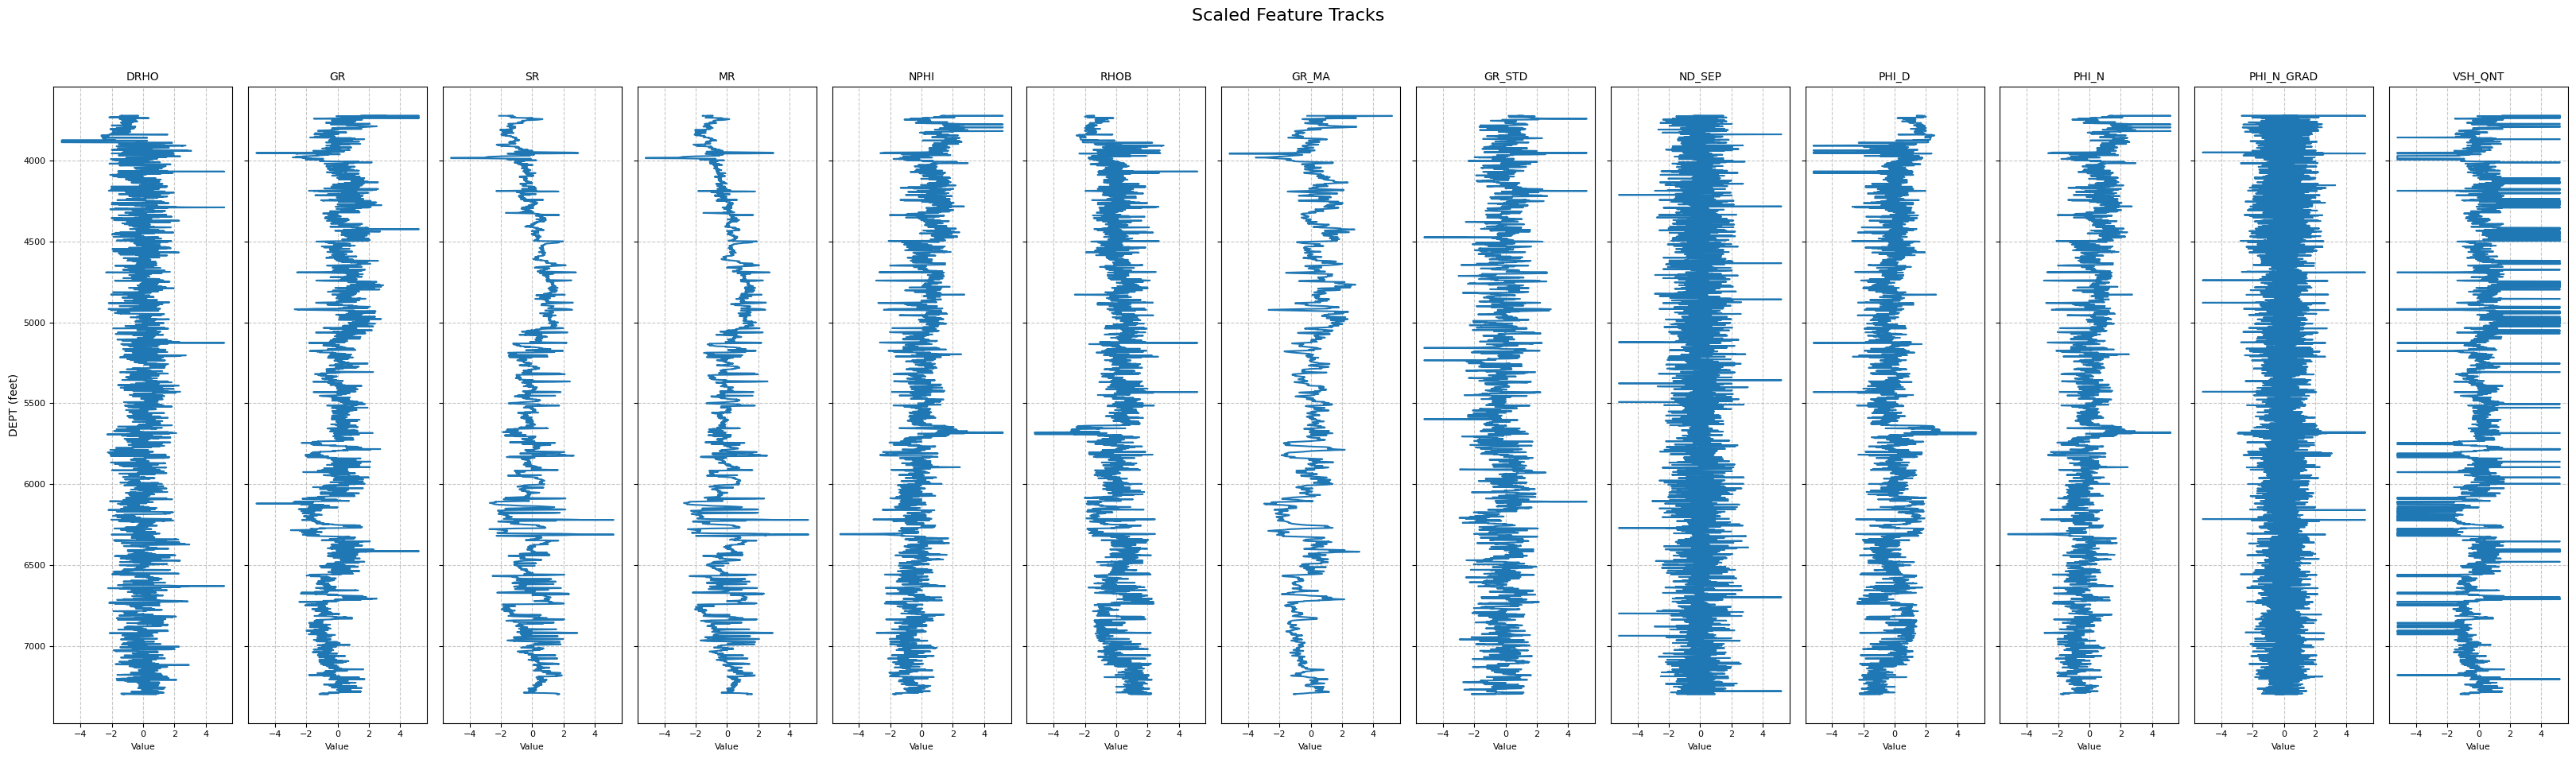

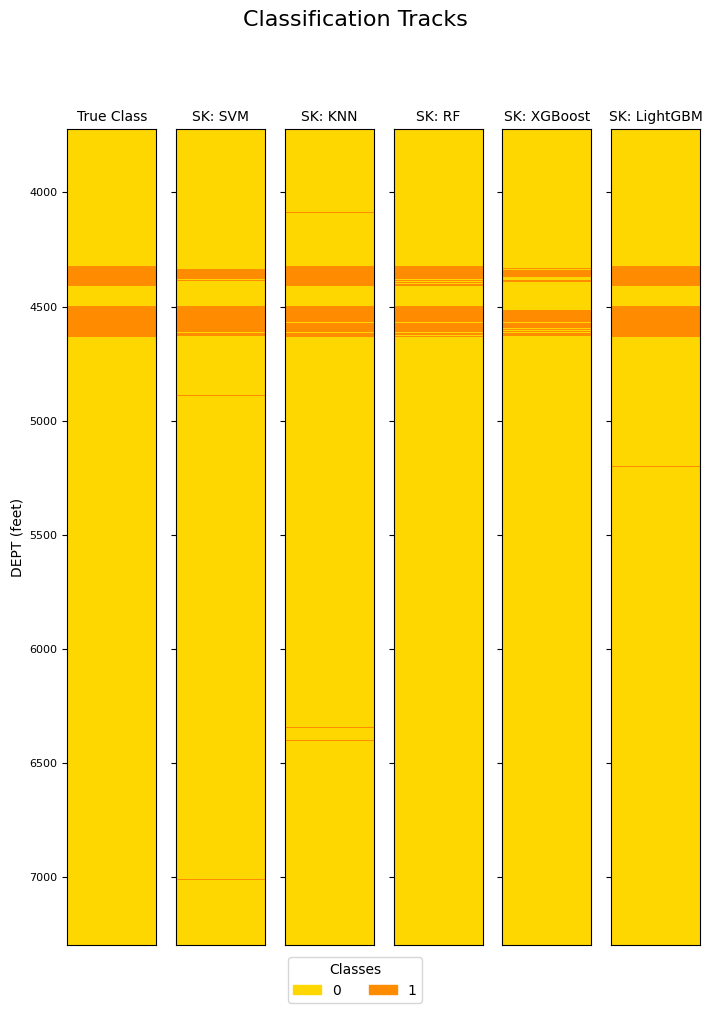

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Ensure all necessary variables are defined from previous cells:
# data, df, y, pred
# X (to get the index for aligning predictions if they are numpy arrays)

if 'DEPT' not in data.columns:
    print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
else:
    depth_column = data['DEPT']
    feature_names = df.columns.tolist()

    # Prepare labels and predictions
    true_labels = y
    all_predictions_to_plot = {}
    all_predictions_to_plot['True Labels'] = true_labels
    for model_name, preds in pred.items():
        all_predictions_to_plot[f'SK: {model_name}'] = preds

    # Define colors for classes
    if isinstance(true_labels, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels))
    else:
        unique_classes = np.sort(true_labels.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])


    # --- Figure 1: feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for feature tracks.")

    # --- Figure 2: scaled feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(X[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for scaled feature tracks.")

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_to_plot)
    if num_classification_plots > 0:
        # Adjust figsize: width per plot can be smaller for classification tracks
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle("Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                if not predictions_data.index.equals(X.index):
                    # This should ideally not happen with consistent data handling
                    # For safety, one might reindex or ensure alignment upstream
                    print(f"Warning: Index mismatch for {title}. Plotting may be incorrect.")
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=X.index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0: # Set Y-axis label only for the first plot in this figure
                ax.set_ylabel("DEPT (feet)", fontsize=10)


        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print("No classification data to plot.")


# Test Wells

## Configuration

In [32]:
# Configuration for test wells
test_wells = ['LLD-14']  # Add more wells here: ["LLD-14", "WELL-X", "WELL-Y"]

# Initialize dictionaries to store results for all test wells
test_wells_data = {}

#! test_feature_cols isnt used in the current 
#! implementation until missing column imputation is
#! implemented. for now, feature_cols are used directly. 
#! Test wells & training well feature columns must be the same
test_feature_cols = {
    'LLD-14': ['DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR'],
}
test_wells_features = {}
test_wells_features_scaled = {}
test_wells_true_labels = {}
test_wells_pred = {}
test_wells_pred_times = {}
test_wells_accuracy = {}

print(f"Configured test wells: {test_wells}")

Configured test wells: ['LLD-14']


## Load Test Wells Data

In [33]:
# Load data for all test wells
for well_name_test in test_wells:
    print(f"\n--- Loading data for {well_name_test} ---")
    
    if not generate_mock_data:
            # Load data from local directory
            test_wells_data[well_name_test] = pd.read_csv(f"../data/processed/{well_name_test}.csv", sep=',')
    else:
        # Generate mock data for test well if needed
        print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name_test}...")
        mock_depth_step = 0.5
        mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
        num_mock_rows = len(mock_dept_values)

        mock_data_dict = {'DEPT': mock_dept_values}

        feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP']

        for col in feature_cols_for_mock:
            mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

        mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

        test_wells_data[well_name_test] = pd.DataFrame(mock_data_dict)

    print(f"{well_name_test} data shape: {test_wells_data[well_name_test].shape}")
    print(f"{well_name_test} data columns: {list(test_wells_data[well_name_test].columns)}")
    print(f"{well_name_test} data head:")
    print(test_wells_data[well_name_test].head())


--- Loading data for LLD-14 ---
LLD-14 data shape: (3507, 46)
LLD-14 data columns: ['DEPT', 'B', 'B1', 'BADHOLE', 'CT', 'CXO', 'DIFFND', 'DRHO', 'DT', 'FTEMP', 'F_APP', 'GR', 'GRN', 'MR', 'SR', 'M', 'MLITH', 'MSFL', 'M_APP', 'NLITH', 'NPHI', 'NPHI_DOL', 'NPHI_LS', 'NPHI_SS', 'PEF', 'PERM', 'PHIA_DN', 'PHIA_NS', 'QV', 'RATIOND', 'RHOB', 'RHOB.1', 'RHOB_ED', 'RHO_MAA', 'RMF', 'ROPS', 'DR', 'RW', 'SFLU', 'U', 'U_MAA', 'VSH', 'VSH_DN', 'VSH_GR', 'VSH_GR1', 'hydrocarbon_formation_class']
LLD-14 data head:
     DEPT       B     B1  BADHOLE      CT     CXO    DIFFND   DRHO  DT  \
0  3052.0  4.5167  0.046      0.0  1.6978  1.6529       NaN -0.047 NaN   
1  3052.5  4.5167  0.046      0.0  1.6978  1.6556 -0.087730 -0.055 NaN   
2  3053.0  4.5167  0.046      0.0  1.7794  1.7212 -0.102385 -0.055 NaN   
3  3053.5  4.5167  0.046      0.0  1.7825  1.7271 -0.104524 -0.053 NaN   
4  3054.0  4.5167  0.046      0.0  1.7575  1.7007 -0.100691 -0.047 NaN   

      FTEMP  ...     DR        RW   SFLU       U

## Imput Data & Feature engineering

In [34]:
for well_name_test in test_wells:
    test_wells_data[well_name_test] = test_wells_data[well_name_test].fillna(test_wells_data[well_name_test].mean())
    test_wells_data[well_name_test] = compute_engineered_features(test_wells_data[well_name_test], depth_col='DEPT')
    test_wells_data[well_name_test] = test_wells_data[well_name_test].replace([np.inf, -np.inf], np.nan)
    test_wells_data[well_name_test] = test_wells_data[well_name_test].fillna(test_wells_data[well_name_test].mean())

Engineered feature columns added:
['GR_MA', 'GR_STD', 'MSFL_MA', 'MSFL_STD', 'ND_SEP', 'PHI_D', 'PHI_N', 'PHI_N_GRAD', 'VSH_QNT']  
 total new: 9


## Extract features

In [35]:
# Extract features from all test wells data (same features as used for training)
for well_name_test in test_wells:
    print(f"\n--- Extracting features for {well_name_test} ---")
    
    test_wells_features[well_name_test] = test_wells_data[well_name_test][feature_cols]
    # replace above with the line below if you want to use different features for each well, after support for missing column is added (imputation)
    # test_wells_features[well_name_test] = test_wells_data[well_name_test][test_feature_cols[well_name_test]]
    test_wells_true_labels[well_name_test] = test_wells_data[well_name_test]['hydrocarbon_formation_class']

    print(f"{well_name_test} features shape: {test_wells_features[well_name_test].shape}")
    print(f"{well_name_test} class distribution:")
    print(test_wells_true_labels[well_name_test].value_counts())
    print(f"{well_name_test} features head:")
    print(test_wells_features[well_name_test].head())


--- Extracting features for LLD-14 ---
LLD-14 features shape: (3507, 13)
LLD-14 class distribution:
hydrocarbon_formation_class
0    3072
1     435
Name: count, dtype: int64
LLD-14 features head:
    DRHO      GR     SR     MR      NPHI      RHOB      GR_MA    GR_STD  \
0 -0.047  43.252  0.811  0.597  0.452917  1.763000  65.641193  4.187909   
1 -0.055  38.836  0.810  0.594  0.451300  1.724000  65.641193  4.187909   
2 -0.055  36.523  0.805  0.574  0.448100  1.711000  39.537000  3.418832   
3 -0.053  37.434  0.804  0.572  0.447900  1.709518  39.011250  2.982939   
4 -0.047  39.858  0.819  0.581  0.446400  1.715000  39.180600  2.610908   

     ND_SEP     PHI_D     PHI_N  PHI_N_GRAD   VSH_QNT  
0 -0.002142  0.537576  0.452917    0.000057  0.032835  
1 -0.002142  0.561212  0.451300   -0.004817  0.000000  
2 -1.890219  0.569091  0.448100   -0.003400  0.000000  
3 -1.605122  0.569989  0.447900   -0.001700  0.000000  
4 -1.496038  0.566667  0.446400    0.001400  0.000000  


## Quantile Transformation

In [36]:
# Apply quantile transformation to all test wells data using the same transformer fitted on training data
# We need to use the same transformer that was fitted on the training data (X_train from LLB-10)
# Since we don't have access to the original transformer, we'll refit it on the original LLB-10 training data

# First, get the original training data before SMOTE and scaling
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)

# Create and fit the quantile transformer on original LLB-10 training data
qt_transformer_for_test_wells = QuantileTransformer(output_distribution='normal')
qt_transformer_for_test_wells.fit(X_train_original)

# Transform all test wells data using the same transformer
for well_name_test in test_wells:
    print(f"\n--- Applying quantile transformation to {well_name_test} ---")
    
    test_wells_features_scaled[well_name_test] = pd.DataFrame(
        qt_transformer_for_test_wells.transform(test_wells_features[well_name_test])
    )
    test_wells_features_scaled[well_name_test].columns = test_wells_features[well_name_test].columns.values
    test_wells_features_scaled[well_name_test].index = test_wells_features[well_name_test].index.values

    print(f"{well_name_test} data after quantile transformation:")
    print(test_wells_features_scaled[well_name_test].describe())
    print(f"{well_name_test} scaled data head:")
    print(test_wells_features_scaled[well_name_test].head())


--- Applying quantile transformation to LLD-14 ---
LLD-14 data after quantile transformation:
              DRHO           GR           SR           MR         NPHI  \
count  3507.000000  3507.000000  3507.000000  3507.000000  3507.000000   
mean     -0.801352     0.585904    -0.513321    -1.847568     0.880937   
std       0.873219     1.133196     0.854735     1.305839     0.659234   
min      -2.374537    -2.940733    -2.181747    -5.199338    -5.199338   
25%      -1.435477    -0.200658    -1.006211    -2.507208     0.686350   
50%      -0.857097     0.707653    -0.768075    -1.903724     0.977487   
75%      -0.313703     1.436087    -0.161281    -1.311992     1.239741   
max       1.961708     5.199338     5.199338     5.199338     2.091694   

              RHOB        GR_MA       GR_STD       ND_SEP        PHI_D  \
count  3507.000000  3507.000000  3507.000000  3507.000000  3507.000000   
mean     -1.196490     0.686338    -0.039900    -0.052895     1.196490   
std       0.9825

## Predict using existing model trained on LLB-10

In [37]:
# Make predictions on all test wells data using LLB-10 trained models
print("Making predictions on all test wells data using LLB-10 trained models...")
print("="*80)

for well_name_test in test_wells:
    print(f"\n--- Predicting for {well_name_test} ---")
    
    # Initialize dictionaries for this well
    test_wells_pred[well_name_test] = {}
    test_wells_pred_times[well_name_test] = {}

    for model_name in models.keys():
        print(f"\n--- Predicting with {model_name} for {well_name_test} ---")
        
        # scikit-learn predictions
        if model_name in models:
            print(f"{model_name} prediction...")
            best_sk_model = models[model_name].best_estimator_
            
            start_time = time.time()
            test_wells_pred[well_name_test][model_name] = best_sk_model.predict(test_wells_features_scaled[well_name_test])
            end_time = time.time()
            test_wells_pred_times[well_name_test][model_name] = end_time - start_time

            print(f"{model_name} prediction completed in {test_wells_pred_times[well_name_test][model_name]:.4f} seconds")
            print(f"Prediction shape: {test_wells_pred[well_name_test][model_name].shape}")
            print(f"Predicted class distribution: {np.unique(test_wells_pred[well_name_test][model_name], return_counts=True)}")

print(f"\nAll predictions completed for {len(test_wells)} test wells!")
for well_name_test in test_wells:
    print(f"{well_name_test} - models predicted: {list(test_wells_pred[well_name_test].keys())}")


Making predictions on all test wells data using LLB-10 trained models...

--- Predicting for LLD-14 ---

--- Predicting with SVM for LLD-14 ---
SVM prediction...
SVM prediction completed in 0.1128 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([3146,  361]))

--- Predicting with KNN for LLD-14 ---
KNN prediction...
KNN prediction completed in 0.1751 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([3346,  161]))

--- Predicting with RF for LLD-14 ---
RF prediction...
RF prediction completed in 0.0080 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([3392,  115]))

--- Predicting with XGBoost for LLD-14 ---
XGBoost prediction...
XGBoost prediction completed in 0.0050 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([3243,  264]))

--- Predicting with LightGBM for LLD-14 ---
LightGBM prediction...
LightGBM prediction completed in 0.0062 sec

## LLB-10 trained model on Test Wells: Prediction & Model Evaluation

Evaluating LLB-10 trained models on all test wells data...

==================== LLD-14 EVALUATION ====================

--- Evaluating: SVM on LLD-14 ---

-- scikit-learn SVM --
Accuracy on LLD-14: 0.8934
F1-Score on LLD-14: 0.5302
AUC-ROC on LLD-14: 0.8201
Prediction Duration: 0.1128 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3072
           1       0.58      0.49      0.53       435

    accuracy                           0.89      3507
   macro avg       0.76      0.72      0.74      3507
weighted avg       0.89      0.89      0.89      3507

Confusion Matrix:
[[2922  150]
 [ 224  211]]


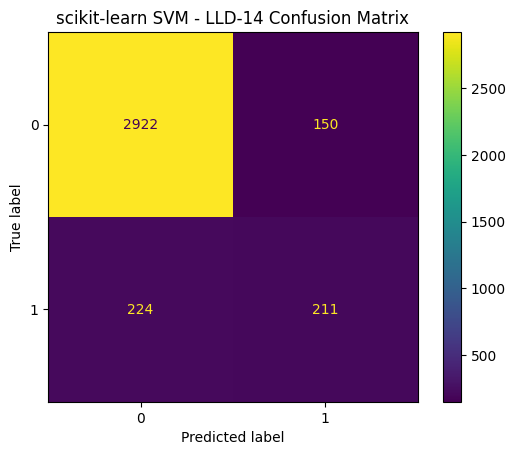



--- Evaluating: KNN on LLD-14 ---

-- scikit-learn KNN --
Accuracy on LLD-14: 0.9002
F1-Score on LLD-14: 0.4128
AUC-ROC on LLD-14: 0.7209
Prediction Duration: 0.1751 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3072
           1       0.76      0.28      0.41       435

    accuracy                           0.90      3507
   macro avg       0.84      0.64      0.68      3507
weighted avg       0.89      0.90      0.88      3507

Confusion Matrix:
[[3034   38]
 [ 312  123]]


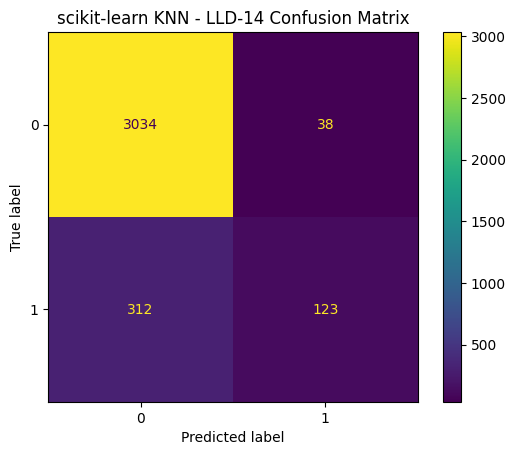



--- Evaluating: RF on LLD-14 ---

-- scikit-learn RF --
Accuracy on LLD-14: 0.8962
F1-Score on LLD-14: 0.3382
AUC-ROC on LLD-14: 0.8348

Top 5 Feature Importance (RF on LLD-14):
  SR: 0.1782
  MR: 0.1518
  GR_MA: 0.1087
  PHI_D: 0.0697
  PHI_N: 0.0636
Prediction Duration: 0.0080 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3072
           1       0.81      0.21      0.34       435

    accuracy                           0.90      3507
   macro avg       0.85      0.60      0.64      3507
weighted avg       0.89      0.90      0.87      3507

Confusion Matrix:
[[3050   22]
 [ 342   93]]


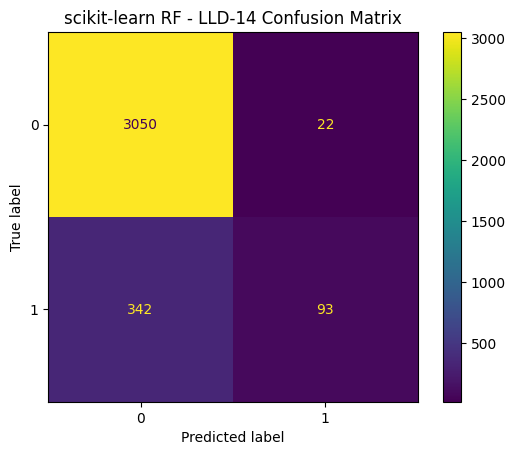



--- Evaluating: XGBoost on LLD-14 ---

-- scikit-learn XGBoost --
Accuracy on LLD-14: 0.8948
F1-Score on LLD-14: 0.4721
AUC-ROC on LLD-14: 0.8224

Top 5 Feature Importance (XGBoost on LLD-14):
  GR_MA: 0.1514
  SR: 0.1456
  NPHI: 0.1149
  MR: 0.1027
  RHOB: 0.0877
Prediction Duration: 0.0050 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3072
           1       0.62      0.38      0.47       435

    accuracy                           0.89      3507
   macro avg       0.77      0.67      0.71      3507
weighted avg       0.88      0.89      0.88      3507

Confusion Matrix:
[[2973   99]
 [ 270  165]]


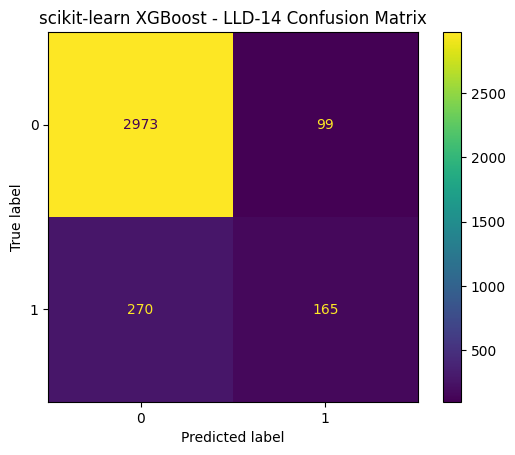



--- Evaluating: LightGBM on LLD-14 ---

-- scikit-learn LightGBM --
Accuracy on LLD-14: 0.9065
F1-Score on LLD-14: 0.5740
AUC-ROC on LLD-14: 0.8415

Top 5 Feature Importance (LightGBM on LLD-14):
  MR: 815.0000
  SR: 784.0000
  GR_MA: 775.0000
  NPHI: 609.0000
  GR_STD: 603.0000
Prediction Duration: 0.0062 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3072
           1       0.66      0.51      0.57       435

    accuracy                           0.91      3507
   macro avg       0.80      0.74      0.76      3507
weighted avg       0.90      0.91      0.90      3507

Confusion Matrix:
[[2958  114]
 [ 214  221]]


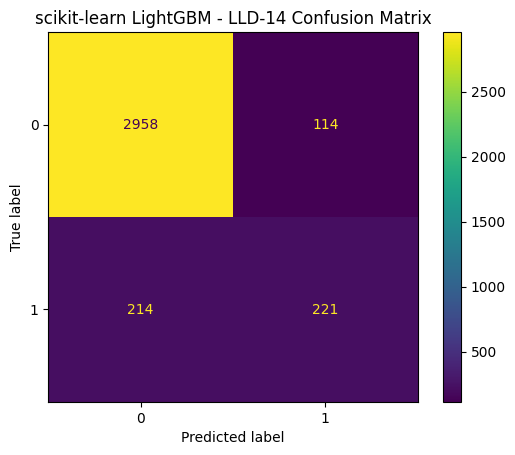



COMPREHENSIVE SUMMARY: LLB-10 trained models performance on all test wells

LLD-14 COMPREHENSIVE METRICS

Metrics Ranked by F1-Score (Best to Worst) for LLD-14:
   Model  Accuracy  F1_Score  AUC_ROC  Prediction_Time
LightGBM    0.9065    0.5740   0.8415           0.0062
     SVM    0.8934    0.5302   0.8201           0.1128
 XGBoost    0.8948    0.4721   0.8224           0.0050
     KNN    0.9002    0.4128   0.7209           0.1751
      RF    0.8962    0.3382   0.8348           0.0080

 BEST MODEL FOR LLD-14: LightGBM
   F1-Score: 0.5740
   AUC-ROC: 0.8415

OVERALL TEST WELLS PERFORMANCE RANKING

Average Performance Across All Test Wells:
          Avg_Accuracy  Avg_F1_Score  Avg_AUC_ROC  Std_F1_Score  Test_Wells_Count
LightGBM        0.9065        0.5740       0.8415        0.0000            1.0000
SVM             0.8934        0.5302       0.8201        0.0000            1.0000
XGBoost         0.8948        0.4721       0.8224        0.0000            1.0000
KNN             0.9002

In [38]:
# Evaluate LLB-10 trained models on all test wells data
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Evaluating LLB-10 trained models on all test wells data...")
print("="*80)

# Initialize per-well results storage
test_wells_f1_scores = {}
test_wells_auc_scores = {}
test_wells_feature_importances = {}

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} EVALUATION {'='*20}")
    
    # Initialize metric dictionaries for this well
    test_wells_accuracy[well_name_test] = {}
    test_wells_f1_scores[well_name_test] = {}
    test_wells_auc_scores[well_name_test] = {}
    test_wells_feature_importances[well_name_test] = {}
    
    for model_name in models.keys():
        print(f"\n--- Evaluating: {model_name} on {well_name_test} ---")
        
        # --- scikit-learn model evaluation ---
        if model_name in test_wells_pred[well_name_test]:
            print(f"\n-- scikit-learn {model_name} --")
            best_sk_model = models[model_name].best_estimator_
            
            # Get predictions and true labels
            y_pred_test = test_wells_pred[well_name_test][model_name]
            y_true_test = test_wells_true_labels[well_name_test]
            
            # Get prediction probabilities for AUC calculation (if available)
            try:
                y_pred_proba_test = best_sk_model.predict_proba(test_wells_features_scaled[well_name_test])[:, 1]
                auc_available = True
            except AttributeError:
                print("Note: predict_proba not available for this model - AUC cannot be calculated")
                auc_available = False
            
            # Calculate accuracy
            accuracy_sk = accuracy_score(y_true_test, y_pred_test)
            test_wells_accuracy[well_name_test][model_name] = accuracy_sk
            print(f"Accuracy on {well_name_test}: {accuracy_sk:.4f}")
            
            # Calculate F1-Score
            f1_sk = f1_score(y_true_test, y_pred_test)
            test_wells_f1_scores[well_name_test][model_name] = f1_sk
            print(f"F1-Score on {well_name_test}: {f1_sk:.4f}")
            
            # Calculate AUC-ROC (if probabilities are available)
            if auc_available:
                auc_sk = roc_auc_score(y_true_test, y_pred_proba_test)
                test_wells_auc_scores[well_name_test][model_name] = auc_sk
                print(f"AUC-ROC on {well_name_test}: {auc_sk:.4f}")
            else:
                test_wells_auc_scores[well_name_test][model_name] = np.nan
                print("AUC-ROC: N/A (requires probability predictions)")
            
            # Feature Importance for tree-based models
            if hasattr(best_sk_model, 'feature_importances_'):
                importances = best_sk_model.feature_importances_
                test_wells_feature_importances[well_name_test][model_name] = dict(zip(feature_cols, importances))
                
                print(f"\nTop 5 Feature Importance ({model_name} on {well_name_test}):")
                # Sort features by importance and show top 5
                sorted_features = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
                for feature, importance in sorted_features[:5]:
                    print(f"  {feature}: {importance:.4f}")
            
            # Prediction time
            print(f"Prediction Duration: {test_wells_pred_times[well_name_test][model_name]:.4f} seconds")

            # Classification report
            print("Classification Report:")
            print(classification_report(test_wells_true_labels[well_name_test], test_wells_pred[well_name_test][model_name]))

            # Confusion Matrix
            print("Confusion Matrix:")
            cm_sk = confusion_matrix(test_wells_true_labels[well_name_test], test_wells_pred[well_name_test][model_name])
            print(cm_sk)
            
            # Plot confusion matrix
            disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=[0, 1])
            disp_sk.plot()
            plt.title(f"scikit-learn {model_name} - {well_name_test} Confusion Matrix")
            plt.show()
        
        
        
        print("\n" + "="*40)

print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY: LLB-10 trained models performance on all test wells")
print("="*80)

# Create comprehensive metrics comparison for test wells
for well_name_test in test_wells:
    print(f"\n{'='*60}")
    print(f"{well_name_test} COMPREHENSIVE METRICS")
    print(f"{'='*60}")
    
    # Create DataFrame for this well's metrics
    well_models = list(test_wells_accuracy[well_name_test].keys())
    
    if len(well_models) > 0:
        well_metrics_df = pd.DataFrame({
            'Model': well_models,
            'Accuracy': [test_wells_accuracy[well_name_test][model] for model in well_models],
            'F1_Score': [test_wells_f1_scores[well_name_test][model] for model in well_models],
            'AUC_ROC': [test_wells_auc_scores[well_name_test][model] for model in well_models],
            'Prediction_Time': [test_wells_pred_times[well_name_test][model] for model in well_models]
        })
        
        # Sort by F1-Score (most important for imbalanced datasets)
        well_metrics_df = well_metrics_df.sort_values('F1_Score', ascending=False)
        
        print(f"\nMetrics Ranked by F1-Score (Best to Worst) for {well_name_test}:")
        print(well_metrics_df.to_string(index=False, float_format='%.4f'))
        
        # Highlight the best performing model for this well
        best_model_well = well_metrics_df.iloc[0]['Model']
        best_f1_well = well_metrics_df.iloc[0]['F1_Score']
        best_auc_well = well_metrics_df.iloc[0]['AUC_ROC']
        
        print(f"\n BEST MODEL FOR {well_name_test}: {best_model_well}")
        print(f"   F1-Score: {best_f1_well:.4f}")
        if not np.isnan(best_auc_well):
            print(f"   AUC-ROC: {best_auc_well:.4f}")
    else:
        print(f"No model predictions available for {well_name_test}")

# Overall test wells performance summary
print(f"\n{'='*80}")
print("OVERALL TEST WELLS PERFORMANCE RANKING")
print(f"{'='*80}")

# Calculate average metrics across all test wells for each model
overall_metrics = {}
for model_name in model_names:
    accuracies = [test_wells_accuracy[well][model_name] for well in test_wells if model_name in test_wells_accuracy[well]]
    f1_scores = [test_wells_f1_scores[well][model_name] for well in test_wells if model_name in test_wells_f1_scores[well]]
    auc_scores = [test_wells_auc_scores[well][model_name] for well in test_wells if model_name in test_wells_auc_scores[well] and not np.isnan(test_wells_auc_scores[well][model_name])]
    
    if len(accuracies) > 0:
        overall_metrics[model_name] = {
            'Avg_Accuracy': np.mean(accuracies),
            'Avg_F1_Score': np.mean(f1_scores),
            'Avg_AUC_ROC': np.mean(auc_scores) if len(auc_scores) > 0 else np.nan,
            'Std_F1_Score': np.std(f1_scores),
            'Test_Wells_Count': len(accuracies)
        }

if overall_metrics:
    overall_df = pd.DataFrame(overall_metrics).T
    overall_df = overall_df.sort_values('Avg_F1_Score', ascending=False)
    
    print("\nAverage Performance Across All Test Wells:")
    print(overall_df.to_string(float_format='%.4f'))
    
    best_overall_model = overall_df.index[0]
    print(f"\n BEST OVERALL MODEL ACROSS ALL TEST WELLS: {best_overall_model}")
    print(f"   Average F1-Score: {overall_df.loc[best_overall_model, 'Avg_F1_Score']:.4f}")
    if not np.isnan(overall_df.loc[best_overall_model, 'Avg_AUC_ROC']):
        print(f"   Average AUC-ROC: {overall_df.loc[best_overall_model, 'Avg_AUC_ROC']:.4f}")

print(f"\nInterpretation for Test Wells:")
print("- F1-Score: Most important metric for hydrocarbon detection (imbalanced data)")
print("- AUC-ROC: Measures discrimination ability between hydrocarbon and non-hydrocarbon zones")
print("- Lower standard deviation in F1-Score indicates more consistent performance across wells")


==================== LLD-14 FEATURE IMPORTANCE & ROC ANALYSIS ====================


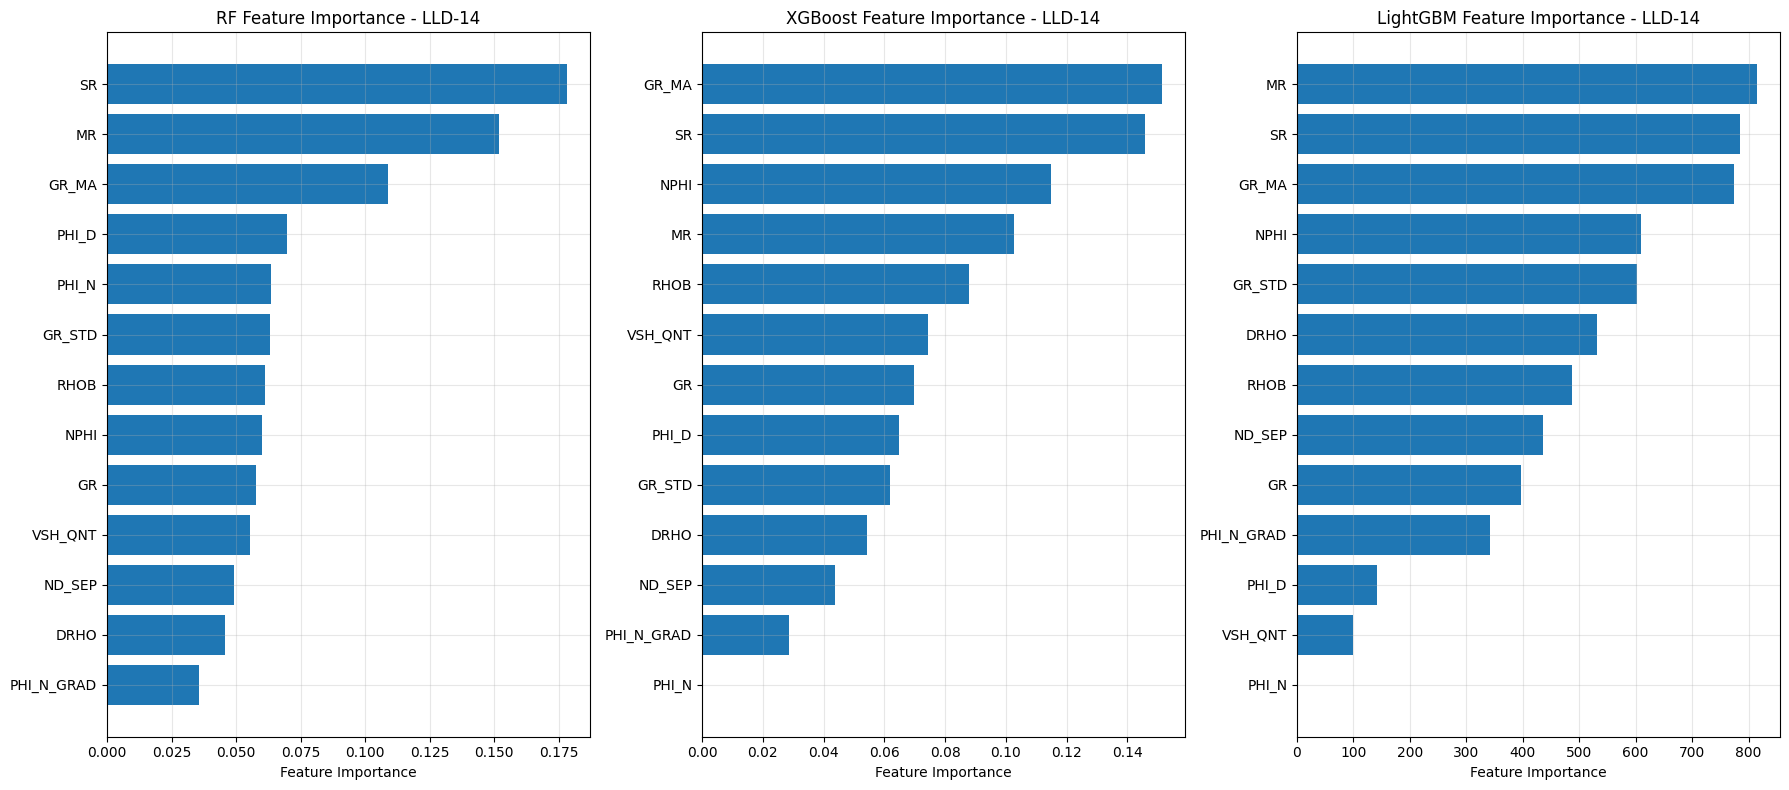

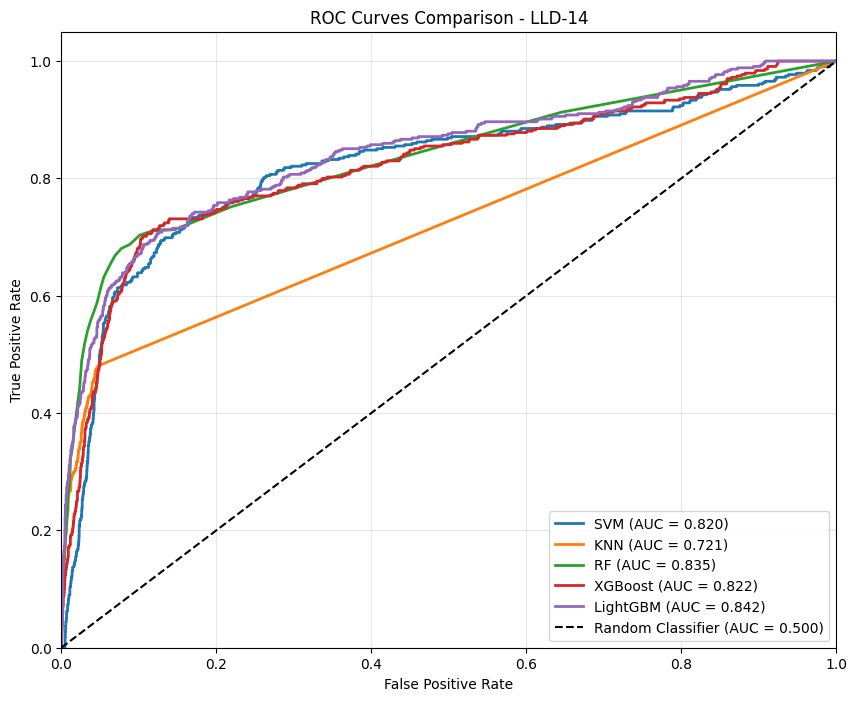

In [39]:
# Feature Importance Plots and ROC Curves for Test Wells
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Iterate through each test well for visualizations
for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} FEATURE IMPORTANCE & ROC ANALYSIS {'='*20}")
    
    # Get the feature importances for this well
    well_feature_importances = test_wells_feature_importances.get(well_name_test, {})
    
    # Feature Importance Plots for Tree-based Models
    tree_models = [name for name in model_names if name in well_feature_importances and name in ['RF', 'XGBoost', 'LightGBM']]
    
    if len(tree_models) > 0:
        fig, axes = plt.subplots(1, len(tree_models), figsize=(6*len(tree_models), 8))
        if len(tree_models) == 1:
            axes = [axes]
        
        for i, model_name in enumerate(tree_models):
            if model_name in well_feature_importances:
                features = list(well_feature_importances[model_name].keys())
                importances = list(well_feature_importances[model_name].values())
                
                # Sort by importance
                sorted_idx = np.argsort(importances)
                
                axes[i].barh(range(len(features)), [importances[j] for j in sorted_idx])
                axes[i].set_yticks(range(len(features)))
                axes[i].set_yticklabels([features[j] for j in sorted_idx])
                axes[i].set_xlabel('Feature Importance')
                axes[i].set_title(f'{model_name} Feature Importance - {well_name_test}')
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No tree-based models with feature importance available for {well_name_test}")
    
    # ROC Curves Comparison for this well
    plt.figure(figsize=(10, 8))
    
    # Get test data for this well
    X_test_well = test_wells_features_scaled[well_name_test]
    y_test_well = test_wells_true_labels[well_name_test]
    
    # Calculate ROC curves for each model
    roc_plotted = False
    for model_name in model_names:
        if model_name in models and model_name in test_wells_pred[well_name_test]:
            best_sk_model = models[model_name].best_estimator_
            
            # Try to get probability predictions
            try:
                y_pred_proba = best_sk_model.predict_proba(X_test_well)[:, 1]
                fpr, tpr, _ = roc_curve(y_test_well, y_pred_proba)
                
                # Get AUC score from our stored results
                if well_name_test in test_wells_auc_scores and model_name in test_wells_auc_scores[well_name_test]:
                    auc_score = test_wells_auc_scores[well_name_test][model_name]
                    if not np.isnan(auc_score):
                        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
                        roc_plotted = True
            except (AttributeError, ValueError) as e:
                # Skip models that don't support probability predictions
                continue
    
    if roc_plotted:
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves Comparison - {well_name_test}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"No ROC curves could be generated for {well_name_test} (no probability predictions available)")
    
    print("="*60)


==================== LLD-14 VISUALIZATION ====================


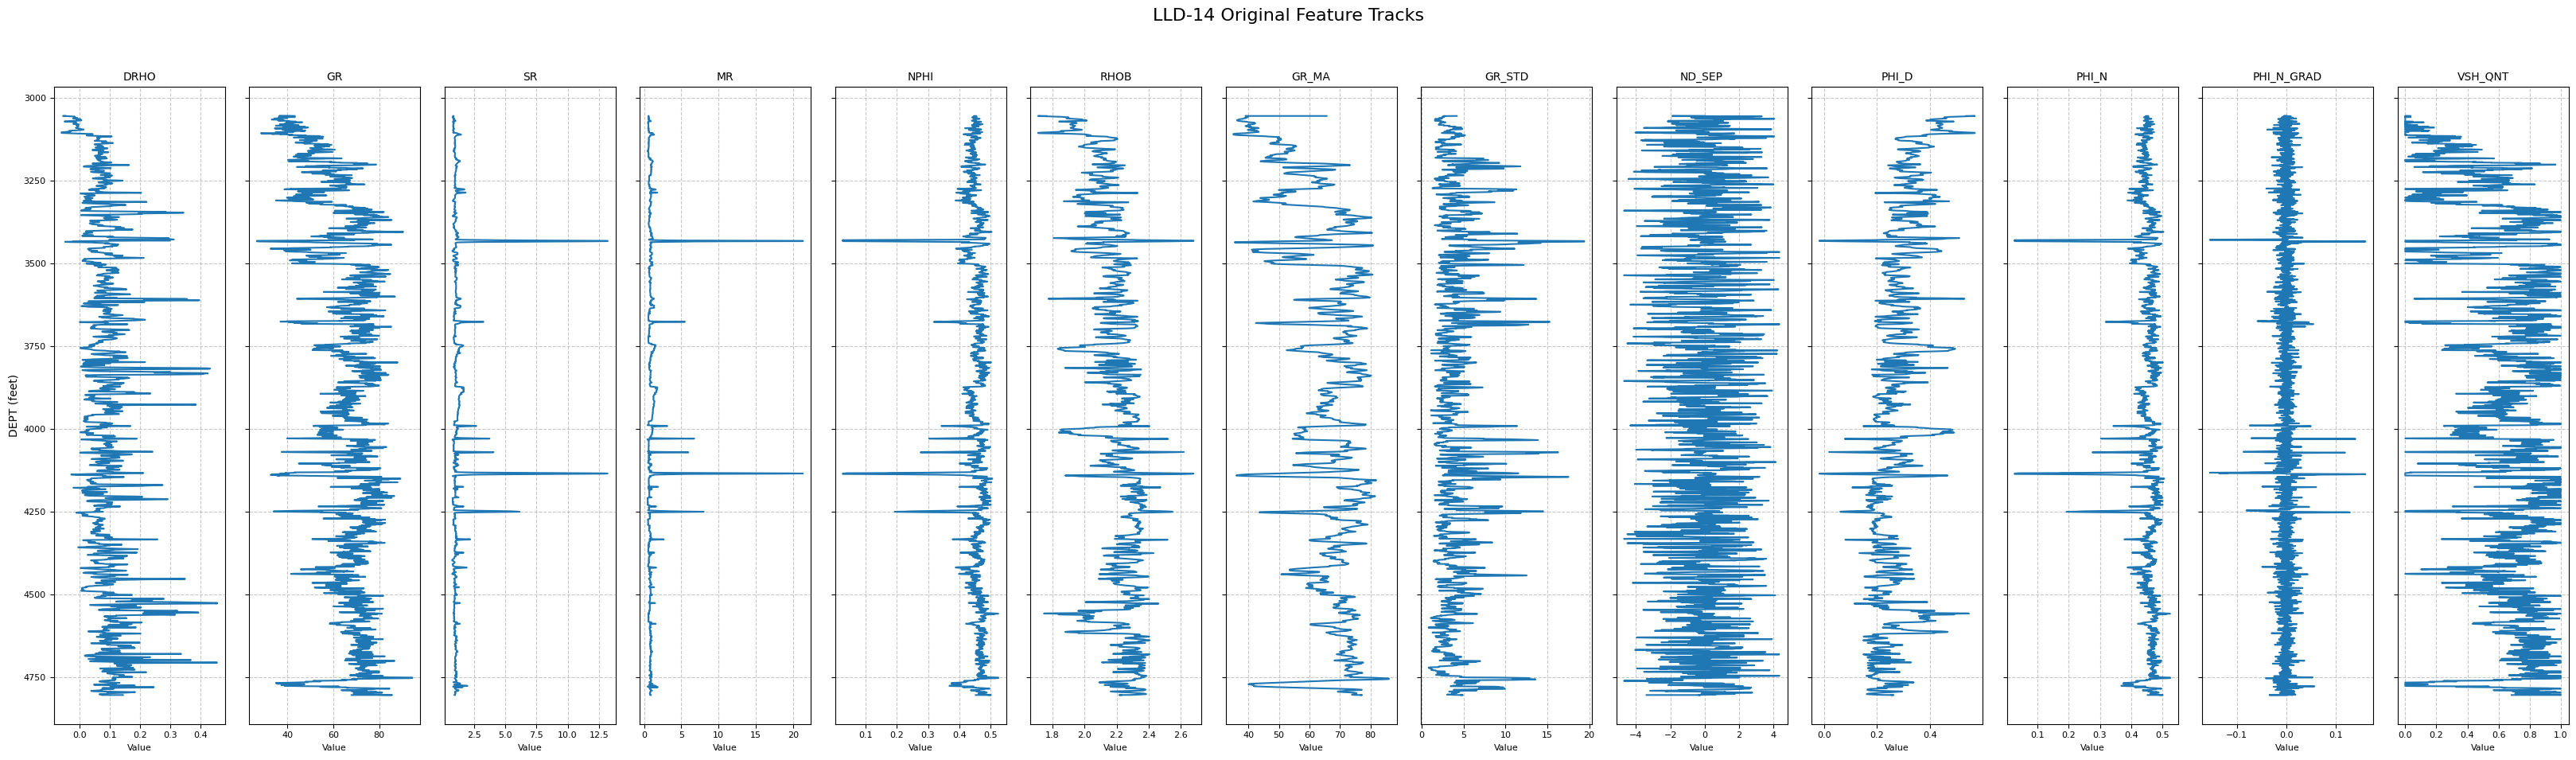

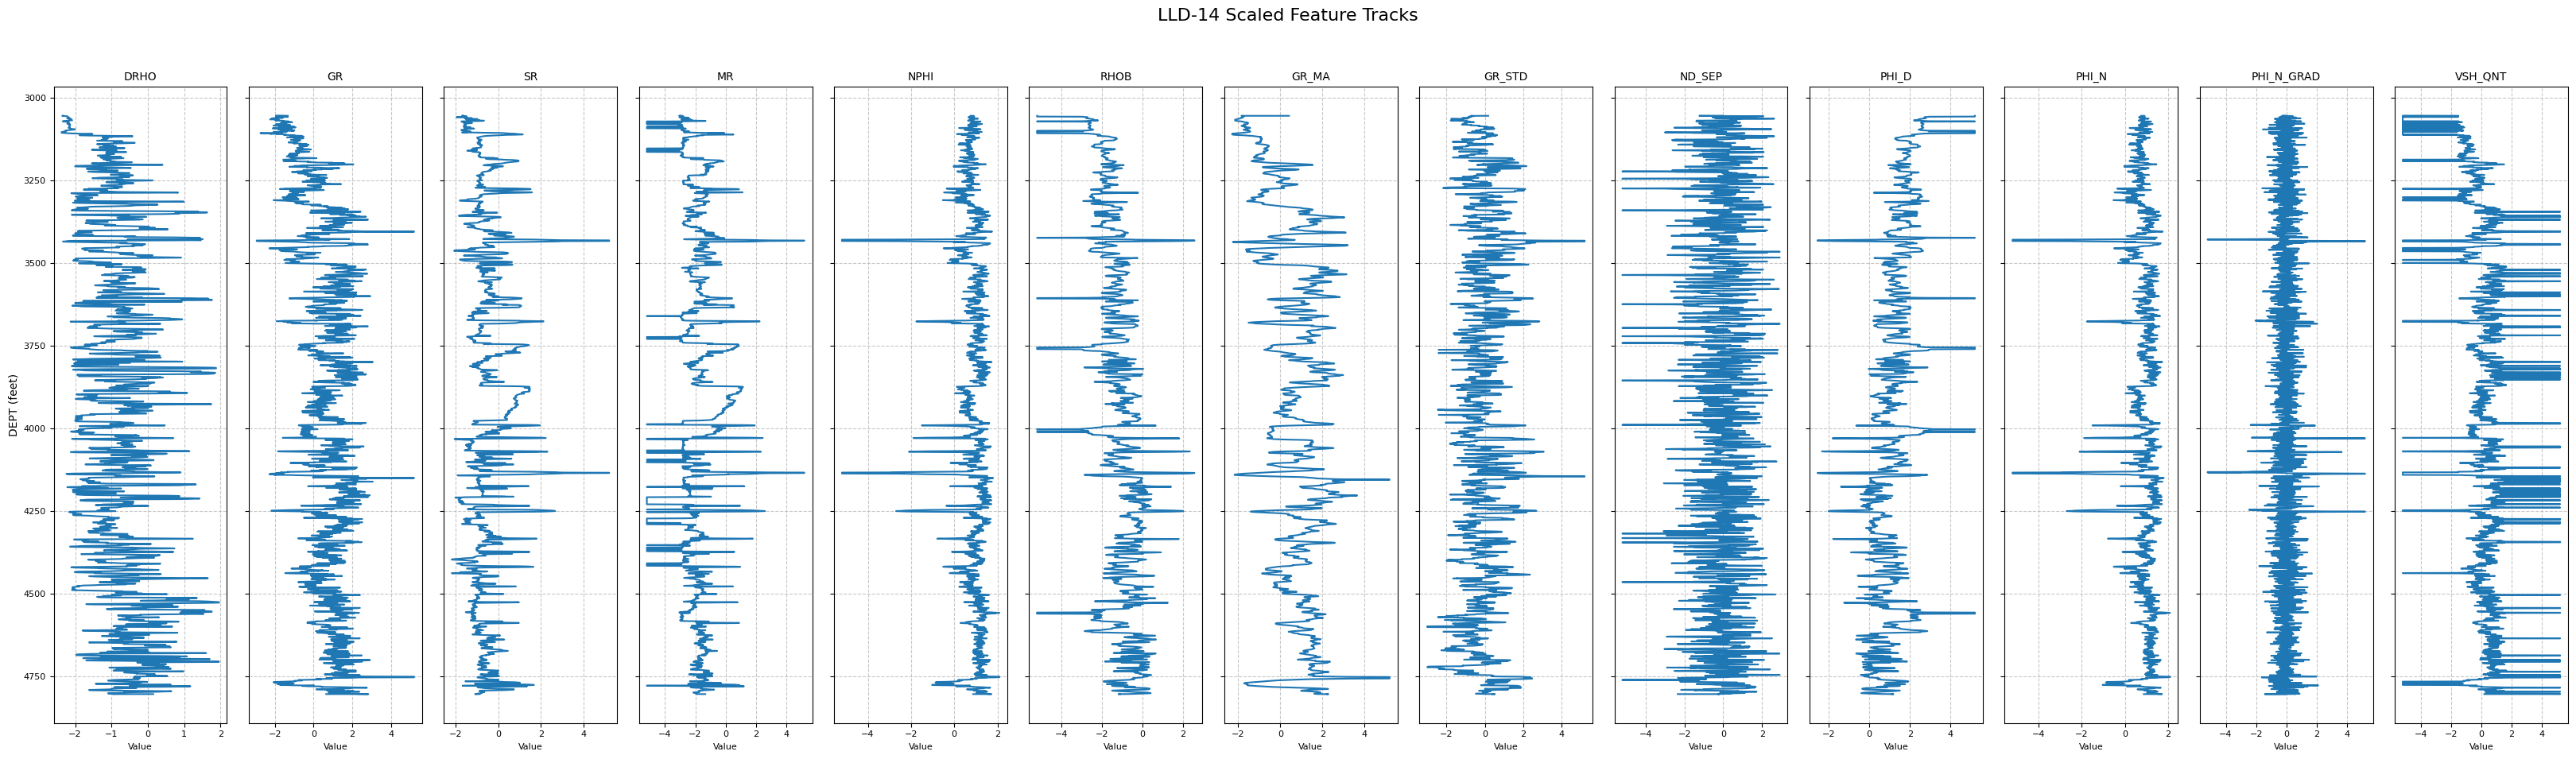

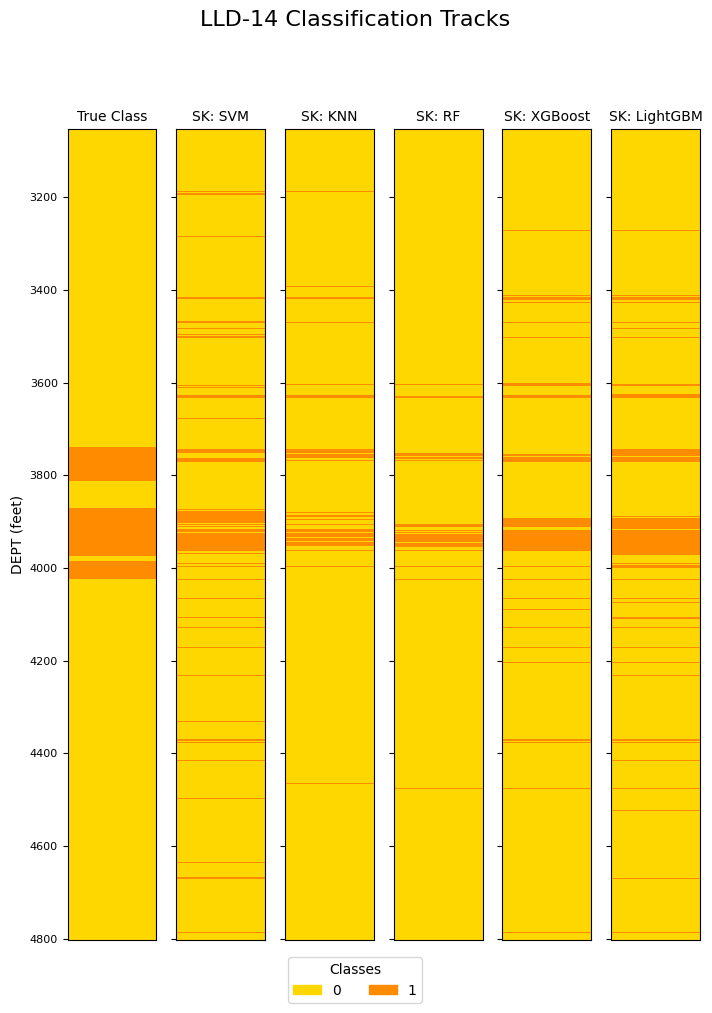

In [40]:
# Create visualization plots for all test wells data and predictions
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} VISUALIZATION {'='*20}")
    
    if 'DEPT' not in test_wells_data[well_name_test].columns:
        print(f"Error: 'DEPT' column not found in {well_name_test} data DataFrame. Cannot generate depth plots.")
        continue
    
    depth_column_test = test_wells_data[well_name_test]['DEPT']
    feature_names = test_wells_features[well_name_test].columns.tolist()

    # Prepare labels and predictions for this test well
    true_labels_test = test_wells_true_labels[well_name_test]
    all_predictions_test_to_plot = {}
    all_predictions_test_to_plot['True Labels'] = true_labels_test
    
    # Add scikit-learn predictions
    for model_name, preds in test_wells_pred[well_name_test].items():
        all_predictions_test_to_plot[f'SK: {model_name}'] = preds


    # Define colors for classes
    if isinstance(true_labels_test, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels_test))
    else:
        unique_classes = np.sort(true_labels_test.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])

    # --- Figure 1: Original Feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features = [axes_features]
        fig_features.suptitle(f"{well_name_test} Original Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(test_wells_data[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 2: Scaled Feature Tracks ---
    if num_feature_plots > 0:
        fig_features_scaled, axes_features_scaled = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features_scaled = [axes_features_scaled]
        fig_features_scaled.suptitle(f"{well_name_test} Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features_scaled[i]
            ax.plot(test_wells_features_scaled[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features_scaled[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_test_to_plot)
    if num_classification_plots > 0:
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle(f"{well_name_test} Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_test_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_test_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=test_wells_features_scaled[well_name_test].index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column_test.max(), depth_column_test.min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)

        # axes_class[0].invert_yaxis()

        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print(f"No classification data to plot for {well_name_test}.")

In [41]:
# Create a simple comparison summary for training and test wells performance using scikit-learn models
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("PERFORMANCE SUMMARY: LLB-10 and TEST WELLS (scikit-learn)")
print("="*80)

# --- Accuracy and timing on LLB-10 ---
summary_rows = []
for model_name in models.keys():
    row = {
        'Model': model_name,
        'LLB-10_Train_Acc': train_accuracy.get(model_name, 'N/A'),
        'LLB-10_Test_Acc': test_accuracy.get(model_name, 'N/A'),
        'LLB-10_CV': crossValidation_accuracy.get(model_name, 'N/A'),
        'LLB-10_Train_Time(s)': times.get(model_name, 'N/A'),
        'LLB-10_Pred_Time(s)': pred_times.get(model_name, 'N/A'),
    }
    # Add test wells metrics if available
    for well_name_test in test_wells:
        acc = None
        pred_t = None
        if well_name_test in test_wells_accuracy and model_name in test_wells_accuracy[well_name_test]:
            acc = test_wells_accuracy[well_name_test][model_name]
        if well_name_test in test_wells_pred_times and model_name in test_wells_pred_times[well_name_test]:
            pred_t = test_wells_pred_times[well_name_test][model_name]
        row[f'{well_name_test}_Test_Acc'] = acc if acc is not None else 'N/A'
        row[f'{well_name_test}_Pred_Time(s)'] = pred_t if pred_t is not None else 'N/A'
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\nPerformance Summary Table:")
print(summary_df.to_string(index=False))


PERFORMANCE SUMMARY: LLB-10 and TEST WELLS (scikit-learn)

Performance Summary Table:
   Model  LLB-10_Train_Acc  LLB-10_Test_Acc  LLB-10_CV  LLB-10_Train_Time(s)  LLB-10_Pred_Time(s)  LLD-14_Test_Acc  LLD-14_Pred_Time(s)
     SVM          0.984986         0.971389   0.976956              5.840676             0.165215         0.893356             0.112802
     KNN          1.000000         0.972087   0.969796              0.859565             0.228672         0.900200             0.175072
      RF          0.999825         0.965108   0.970494              6.335016             0.010055         0.896208             0.007953
 XGBoost          0.978527         0.963015   0.610380              2.674052             0.003506         0.894782             0.005004
LightGBM          1.000000         0.983950   0.867016             36.607414             0.004646         0.906473             0.006175


# Layer by layer Hydrocarbon analysis


This section segregates the machine learning results for a well based on the predefined `layer_boundaries`. For each layer, it calculates the percentage of data points classified as hydrocarbon-positive (class 1). A layer is designated as 'Hydrocarbon' if this percentage is greater than `hydrocarbon_percentage_threshold`, and 'Non-Hydrocarbon' otherwise.


In [42]:
hydrocarbon_percentage_threshold = 25

## Layer boundaries

In [43]:
layer_boundaries = {}
layer_boundaries['LLB-10'] = [
    2199,
    2249,
    2556,
    2693,
    2726,
    2871,
    2886,
    2957,
    2978,
    3052,
    3078,
    3155,
    3197,
    3399,
    3408,
    3568,
    3644,
    3658,
    3738,
    3772,
    3811,
    3873,
    3937,
    3957,
    3969,
    4005,
    4183,
    4198,
    4204,
    4217,
    4321,
    4410,
    4497,
    4632,
    4643,
    4697,
    4875,
    4891,
    4915,
    4928,
    5031,
    5041,
    5124,
    5144,
    5170,
    5190,
    5309,
    5384,
    5444,
    5468,
    5734,
    5764,
    5791,
    5839,
    5901,
    5951,
    6073,
    6095,
    6102,
    6123,
    6137,
    6323,
    6421,
    6683,
    6720,
    6976,
    7148,
    7362,
    7529,
    7547,
    7554,
    8736,
    8779,
    8854,
    8873,
    9049,
    9166,
    9228,
    9233,
    9282,
    9284,
    9290,
    9372,
    9399,
    9420,
    9432,
    9441,
    9463,
    9475,
    9483,
    9504,
    9547,
    9558,
    9625,
    9671,
    9685,
    9734,
    9740,
    9802,
    9828,
    9838,
    9870,
    9881,
    9892,
    9914,
    9926,
    9970,
    10019,
    10123,
    10151,
    10185,
    10237,
    10242,
    10245,
    10349,
    10381,
    10394,
    10429,
    10480,
    10505,
    10534,
    10543,
    10571,
    10578,
    10583
]
layer_boundaries['LLA-2'] = [
    3380,
    3493,
    3509,
    3583,
    3603,
    3674,
    3758,
    3859,
    3888,
    3903,
    3957,
    4063,
    4089,
    4123,
    4218,
    4290,
    4366,
    4433,
    4556,
    4566,
    4613,
    4753,
    4769,
    4793,
    4799,
    4887,
    4895,
    4997,
    5019,
    5031,
    5047,
    5142,
    5205,
    5231,
    5257,
    5490,
    5512,
    5540,
    5617,
    5639,
    5659,
    5682,
    5687,
    5724,
    5765,
    5772,
    5901,
    5911,
    5980,
    6030,
    6207,
    6215,
    6367,
    6470,
    6484,
    6576,
    6585,
    6622,
    6631,
    6636,
    6727,
    6782
]
layer_boundaries['LLD-14'] = [
    1908,
    1968,
    2166,
    2284,
    2310,
    2418,
    2434,
    2489,
    2505,
    2542,
    2569,
    2657,
    2663,
    2803,
    2881,
    3009,
    3100,
    3114,
    3184,
    3210,
    3274,
    3324,
    3407,
    3439,
    3448,
    3483,
    3602,
    3637,
    3642,
    3684,
    3740,
    3814,
    3872,
    3976,
    3988,
    4026,
    4131,
    4143,
    4173,
    4176,
    4204,
    4208,
    4243,
    4254,
    4265,
    4272,
    4414,
    4480,
    4582,
    4598,
    4754,
    4782,
    4804,
    4862,
    4871,
    4928,
    4932,
    4995,
    5028,
    5077,
    5085,
    5206,
    5230,
    5303,
    5385,
    5538,
    5559,
    5894,
    5940,
    6015,
    6089,
    6106,
    6175,
    6487,
    6766,
    7046,
    7089,
    7155,
    7240,
    7337,
    7458,
    7521,
    7563,
    7566,
    7630,
    7646,
    7650,
    7657,
    7663,
    7666,
    7690,
    7716,
    7729,
    7762,
    7807,
    7839,
    7851,
    7886,
    7898,
    7956,
    7976,
    7993,
    8018,
    8066,
    8072,
    8083,
    8106,
    8130,
    8139,
    8227,
    8266,
    8287
]

## End of layer boundaries

In [44]:
# Modular functions for layer-by-layer analysis

def prepare_results_dataframe(data_df, true_labels, sk_predictions):
    """
    Prepare a combined dataframe with depth, true labels, and all predictions.

    Args:
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions

    Returns:
        DataFrame with all combined data
    """
    results_df = data_df[['DEPT']].copy()
    results_df['True_Labels'] = true_labels

    # Add scikit-learn predictions
    for model_name, preds in sk_predictions.items():
        results_df[f'SK_{model_name}'] = preds

    return results_df

def analyze_layers(results_df, boundaries, threshold):
    """
    Analyze hydrocarbon percentage for each layer.

    Args:
        results_df: DataFrame with DEPT and prediction columns
        boundaries: List of layer boundary depths
        threshold: Hydrocarbon percentage threshold for classification

    Returns:
        DataFrame with layer analysis results
    """
    layer_analysis_results = []

    for i in range(len(boundaries) - 1):
        start_depth = boundaries[i]
        end_depth = boundaries[i+1]

        # Filter data for the current layer
        layer_data = results_df[(results_df['DEPT'] >= start_depth) & (results_df['DEPT'] < end_depth)]

        if not layer_data.empty:
            layer_info = {
                'Layer': f"{i+1}",
                'Start_Depth': start_depth,
                'End_Depth': end_depth
            }

            # Analyze each prediction column
            for col in results_df.columns:
                if col not in ['DEPT']:
                    hydrocarbon_percentage = layer_data[col].mean() * 100
                    classification = 'Hydrocarbon' if hydrocarbon_percentage > threshold else 'Non-Hydrocarbon'
                    layer_info[f'{col}_HC_%'] = f"{hydrocarbon_percentage:.2f}%"
                    layer_info[f'{col}_Class'] = classification

            layer_analysis_results.append(layer_info)

    return pd.DataFrame(layer_analysis_results)

def analyze_well_layers(well_name, data_df, true_labels, sk_predictions, boundaries, threshold):
    """
    Complete layer analysis for a single well.

    Args:
        well_name: Name of the well (e.g., 'LLB-10', 'LLD-14')
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions
        boundaries: List of layer boundary depths for this well
        threshold: Hydrocarbon percentage threshold for classification

    Returns:
        DataFrame with layer analysis results
    """
    results_df = prepare_results_dataframe(data_df, true_labels, sk_predictions)
    layer_summary = analyze_layers(results_df, boundaries, threshold)
    return layer_summary

def plot_layer_classification_for_well(layer_summary_results, well_name):
    """
    Create visualization for layer-by-layer classification for a specific well.

    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells
        well_name: Name of the well to plot
    """
    if well_name not in layer_summary_results:
        print(f"No layer analysis data found for {well_name}")
        return

    layer_summary_df = layer_summary_results[well_name]

    # Get the list of classification columns to plot
    class_cols = [col for col in layer_summary_df.columns if col.endswith('_Class')]

    # Define colors for the plot
    color_map = {'Non-Hydrocarbon': 'gold', 'Hydrocarbon': 'darkorange'}

    num_plots = len(class_cols)
    if num_plots > 0:
        fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 1.2, 10), sharey=True)
        if num_plots == 1:
            axes = [axes]
        fig.suptitle(f'{well_name} Layer-by-Layer Aggregated Classification', fontsize=16, y=0.98)

        for i, col_name in enumerate(class_cols):
            ax = axes[i]

            # Iterate over each layer in the summary dataframe
            for idx, row in layer_summary_df.iterrows():
                start_depth = row['Start_Depth']
                end_depth = row['End_Depth']
                classification = row[col_name]

                # Get the color for the classification
                color = color_map.get(classification, 'white')

                # Draw a colored block for the layer
                ax.axhspan(start_depth, end_depth, color=color, alpha=1)

            # Formatting the plot
            model_title = col_name.replace('_Class', '').replace('_', ' ')
            ax.set_title(model_title, fontsize=10)
            ax.set_xticks([])
            ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)

            # Set depth limits based on the full range of layers
            ax.set_ylim(layer_summary_df['End_Depth'].max(), layer_summary_df['Start_Depth'].min())

        # Create a legend
        patches = [plt.Rectangle((0,0),1,1, color=color_map[cls]) for cls in color_map]
        legend_labels = list(color_map.keys())
        fig.legend(patches, legend_labels, loc='lower center', ncol=len(legend_labels), 
                  bbox_to_anchor=(0.5, -0.02), title="Layer Classification")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"No layer classification summary data to plot for {well_name}.")

def calculate_all_layer_accuracies(layer_summary_results):
    """
    Calculate layer-level accuracy for each model across all wells.

    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells

    Returns:
        Dictionary with well names as keys and model accuracies as values
    """
    all_accuracies = {}

    for well_name, layer_summary_df in layer_summary_results.items():
        true_layer_classes = layer_summary_df['True_Labels_Class']
        pred_class_cols = [col for col in layer_summary_df.columns 
                          if col.endswith('_Class') and col != 'True_Labels_Class']

        well_accuracies = {}
        for col in pred_class_cols:
            pred_layer_classes = layer_summary_df[col]
            accuracy = accuracy_score(true_layer_classes, pred_layer_classes)
            model_key = col.replace('_Class', '')
            well_accuracies[model_key] = accuracy

        all_accuracies[well_name] = well_accuracies

    return all_accuracies

def print_comprehensive_layer_accuracy_analysis(all_layer_accuracies):
    """
    Print comprehensive layer accuracy analysis for all wells.

    Args:
        all_layer_accuracies: Dictionary with well names as keys and model accuracies as values
    """
    print("LAYER-LEVEL ACCURACY ANALYSIS")
    print("="*60)

    # Print individual well accuracies
    for well_name, accuracies in all_layer_accuracies.items():
        print(f"\n{well_name} Layer-Level Accuracy:")
        print("-" * 30)
        for model_key, accuracy in accuracies.items():
            print(f"{model_key}: {accuracy:.4f}")

    # Create summary comparison if we have multiple wells
    well_names = list(all_layer_accuracies.keys())
    if len(well_names) >= 2:
        print("\n" + "="*60)
        print("LAYER-LEVEL ACCURACY COMPARISON SUMMARY")
        print("="*60)

        # Get all unique model keys
        all_model_keys = set()
        for accuracies in all_layer_accuracies.values():
            all_model_keys.update(accuracies.keys())

        summary_data = []
        for model_key in sorted(all_model_keys):
            row = {'Model': model_key}
            for well_name in well_names:
                if model_key in all_layer_accuracies[well_name]:
                    row[f'{well_name} Layer Accuracy'] = all_layer_accuracies[well_name][model_key]
                else:
                    row[f'{well_name} Layer Accuracy'] = 'N/A'
            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))


## LLB-10

In [45]:
# Initialize layer summary results object
layer_summary_results = {}

# Analyze LLB-10 layers using modular functions
layer_summary_results['LLB-10'] = analyze_well_layers(
    well_name='LLB-10',
    data_df=data,
    true_labels=y,
    sk_predictions=pred,
    boundaries=layer_boundaries['LLB-10'],
    threshold=hydrocarbon_percentage_threshold
)

# Display the summary table
print(f"LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
display(layer_summary_results['LLB-10'])

LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class,SK_XGBoost_HC_%,SK_XGBoost_Class,SK_LightGBM_HC_%,SK_LightGBM_Class
0,18,3658,3738,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,19,3738,3772,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,20,3772,3811,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,21,3811,3873,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
4,22,3873,3937,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
5,23,3937,3957,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
6,24,3957,3969,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,25,3969,4005,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
8,26,4005,4183,0.00%,Non-Hydrocarbon,0.56%,Non-Hydrocarbon,0.56%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
9,27,4183,4198,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon


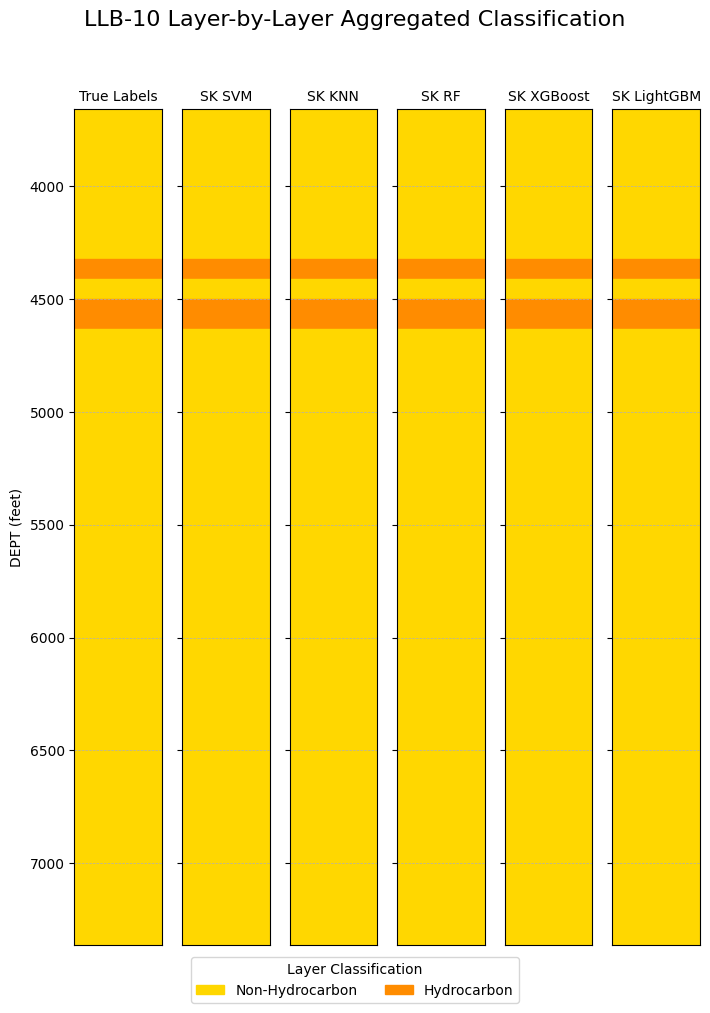

In [46]:
# Visualize LLB-10 layer classification
plot_layer_classification_for_well(layer_summary_results, 'LLB-10')

## Test Wells Layer Analysis


==================== LLD-14 LAYER ANALYSIS ====================
LLD-14 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class,SK_XGBoost_HC_%,SK_XGBoost_Class,SK_LightGBM_HC_%,SK_LightGBM_Class
0,16,3009,3100,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,17,3100,3114,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,3.57%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,18,3114,3184,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,19,3184,3210,0.00%,Non-Hydrocarbon,28.85%,Hydrocarbon,7.69%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
4,20,3210,3274,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,1.56%,Non-Hydrocarbon,1.56%,Non-Hydrocarbon
5,21,3274,3324,0.00%,Non-Hydrocarbon,8.00%,Non-Hydrocarbon,3.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,2.00%,Non-Hydrocarbon,1.00%,Non-Hydrocarbon
6,22,3324,3407,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.60%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,23,3407,3439,0.00%,Non-Hydrocarbon,18.75%,Non-Hydrocarbon,7.81%,Non-Hydrocarbon,1.56%,Non-Hydrocarbon,28.12%,Hydrocarbon,29.69%,Hydrocarbon
8,24,3439,3448,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
9,25,3448,3483,0.00%,Non-Hydrocarbon,11.43%,Non-Hydrocarbon,1.43%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,5.71%,Non-Hydrocarbon,7.14%,Non-Hydrocarbon


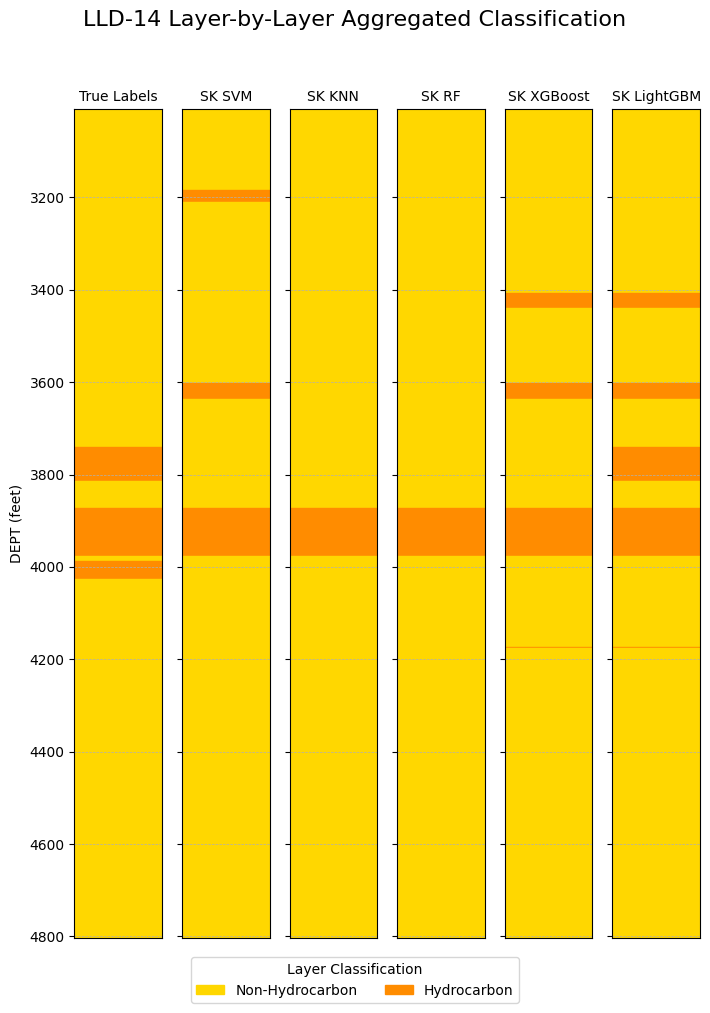

In [47]:
# Analyze layers for all test wells using modular functions
for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} LAYER ANALYSIS {'='*20}")
    
    # Check if layer boundaries exist for this well
    if well_name_test not in layer_boundaries:
        print(f"Warning: No layer boundaries defined for {well_name_test}. Skipping layer analysis.")
        continue
    
    layer_summary_results[well_name_test] = analyze_well_layers(
        well_name=well_name_test,
        data_df=test_wells_data[well_name_test],
        true_labels=test_wells_true_labels[well_name_test],
        sk_predictions=test_wells_pred[well_name_test],
        boundaries=layer_boundaries[well_name_test],
        threshold=hydrocarbon_percentage_threshold,
    )

    # Display the summary table
    print(f"{well_name_test} Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
    display(layer_summary_results[well_name_test])
    
    # Visualize layer classification
    plot_layer_classification_for_well(layer_summary_results, well_name_test)

## Resulting Model Accuracy 

In [48]:
# Calculate and display layer-level accuracies using modular functions
all_layer_accuracies = calculate_all_layer_accuracies(layer_summary_results)
print_comprehensive_layer_accuracy_analysis(all_layer_accuracies)

LAYER-LEVEL ACCURACY ANALYSIS

LLB-10 Layer-Level Accuracy:
------------------------------
SK_SVM: 1.0000
SK_KNN: 1.0000
SK_RF: 1.0000
SK_XGBoost: 1.0000
SK_LightGBM: 1.0000

LLD-14 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.8919
SK_KNN: 0.9459
SK_RF: 0.9459
SK_XGBoost: 0.8649
SK_LightGBM: 0.8919

LAYER-LEVEL ACCURACY COMPARISON SUMMARY
      Model  LLB-10 Layer Accuracy  LLD-14 Layer Accuracy
     SK_KNN                    1.0               0.945946
SK_LightGBM                    1.0               0.891892
      SK_RF                    1.0               0.945946
     SK_SVM                    1.0               0.891892
 SK_XGBoost                    1.0               0.864865


In [49]:
# Execution time
end_notebook = time.time()
print(f"Total notebook execution time: {end_notebook - start_notebook:.2f} seconds")

Total notebook execution time: 62.35 seconds
